In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Exploration des Données (EDA)

### - Importation du dataset et la visualition des premieres lignes

In [2]:
df = pd.read_csv("Invistico_Airline.csv")

In [3]:
df.head()

satisfaction  Gender   Customer Type  Age   Type of Travel     Class  \
0    satisfied  Female  Loyal Customer   65  Personal Travel       Eco   
1    satisfied    Male  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Female  Loyal Customer   15  Personal Travel       Eco   
3    satisfied  Female  Loyal Customer   60  Personal Travel       Eco   
4    satisfied  Female  Loyal Customer   70  Personal Travel       Eco   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   
3              623             0                                  0   
4              354             0                                  0   

   Food and drink  ...  Online support  Ease of Online booking  \
0               0  ...               2                       3   
1               0  ...               2                       3   
2               0  ...               2                       2   
3               0  ...               3                       1   
4               0  ...               4                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                           0   
3            1                3                           0   
4            2                5                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                     305.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 23 columns]

### - Analyse des types de donnees

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

### Detection des valeurs manquantes

In [5]:
df.isnull().sum()

satisfaction                           0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

## les valeurs aberrantes

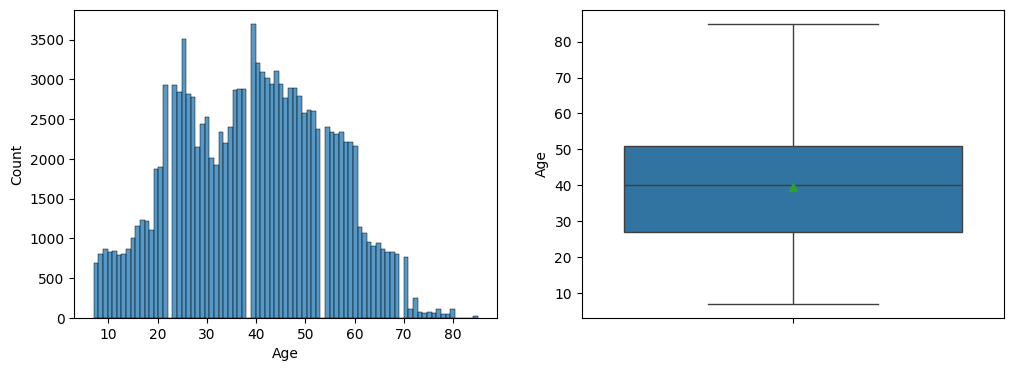

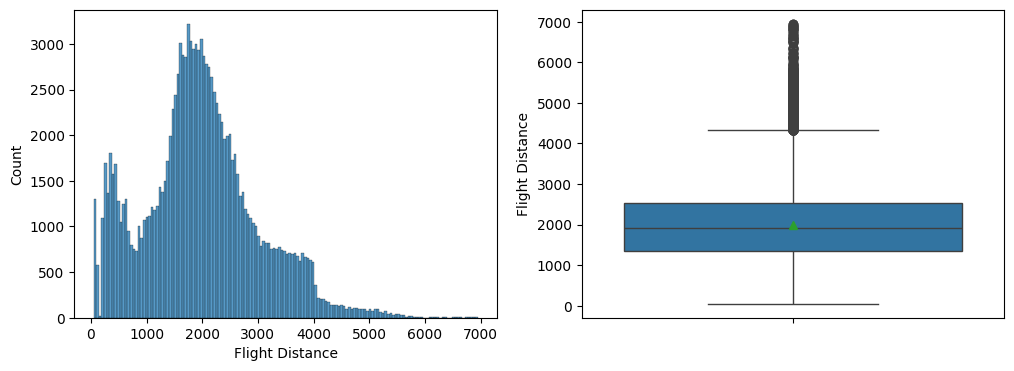

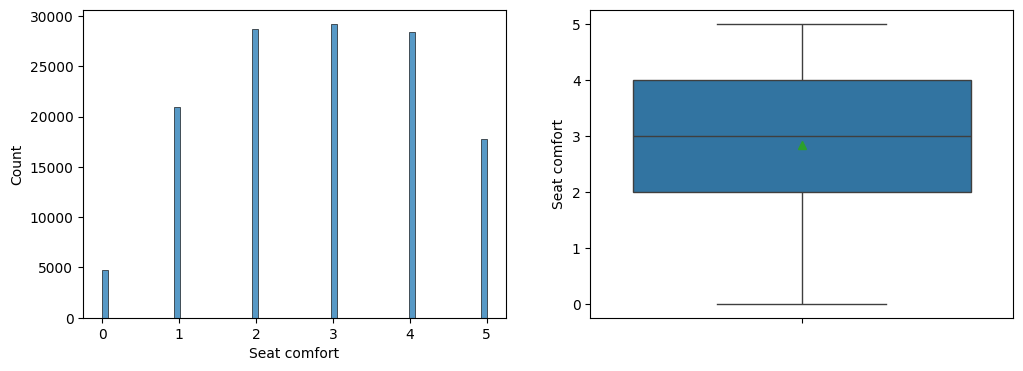

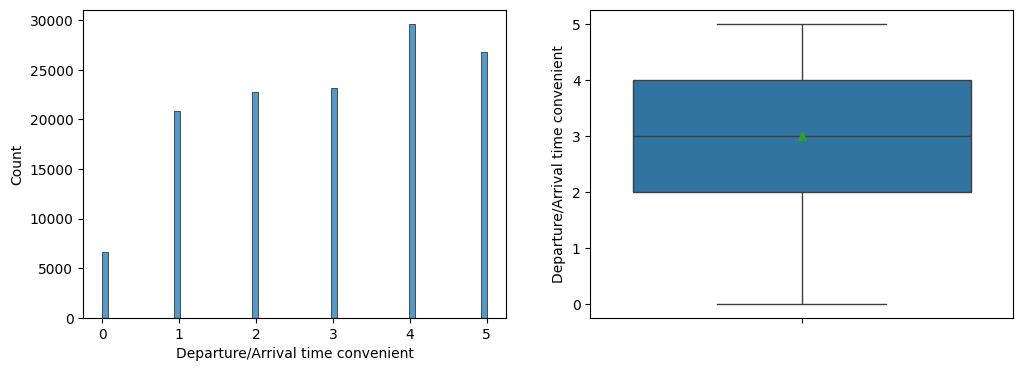

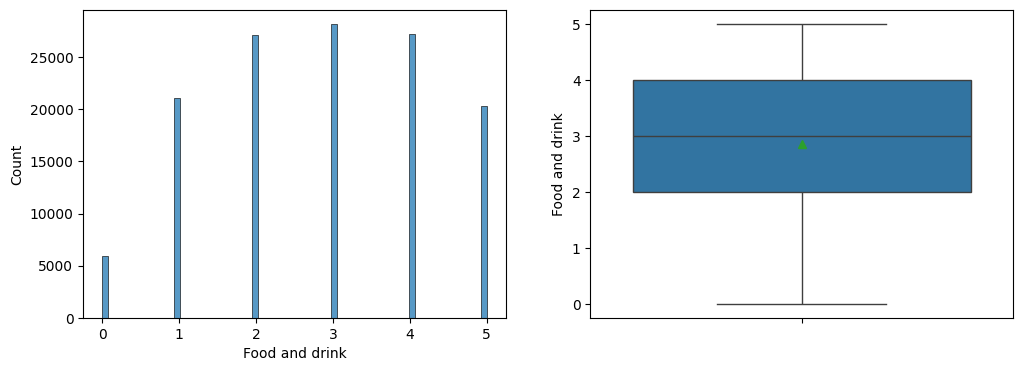

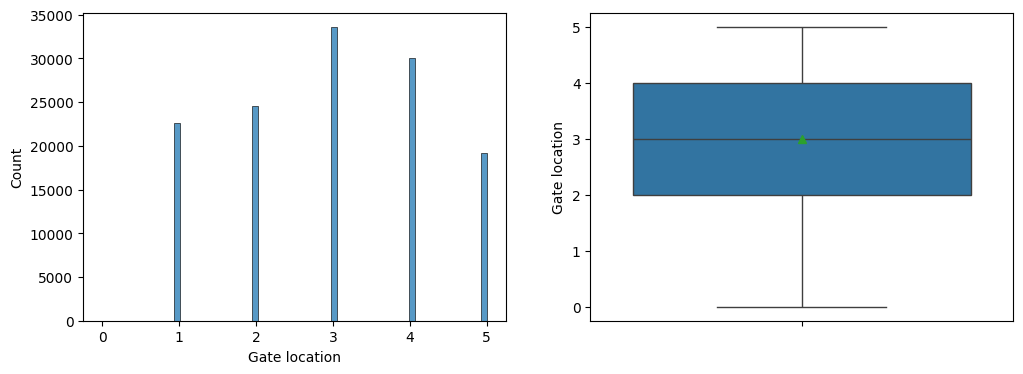

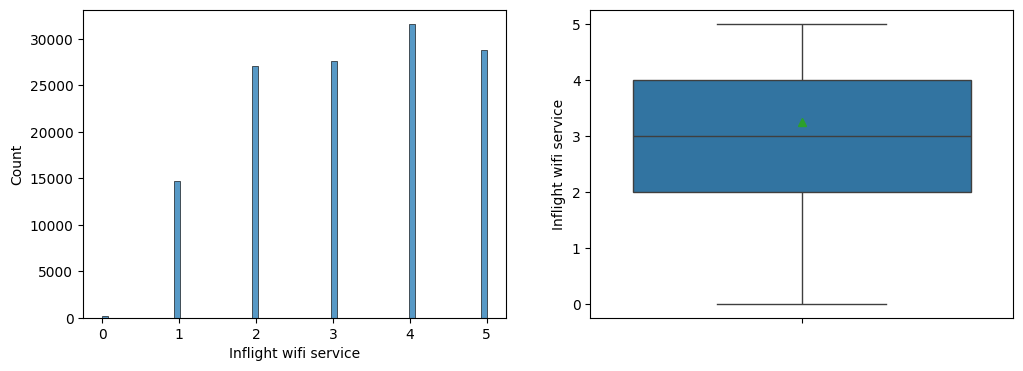

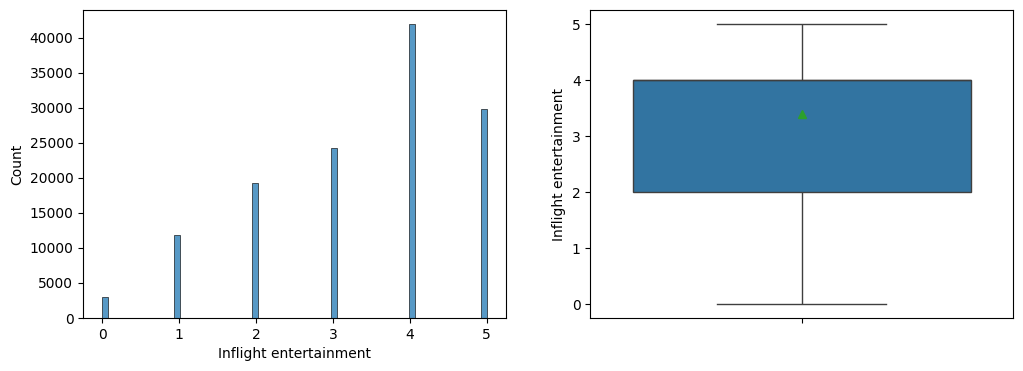

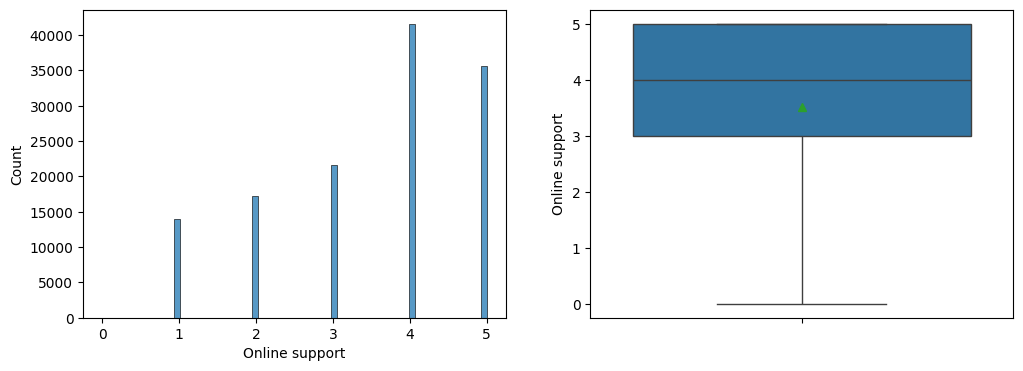

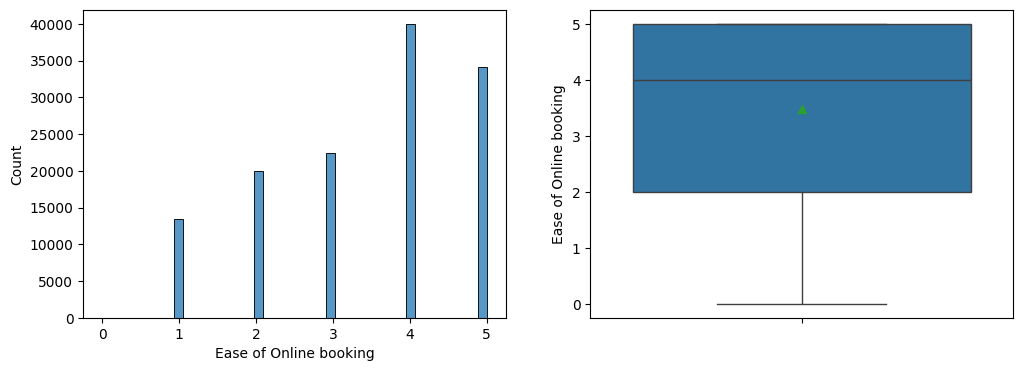

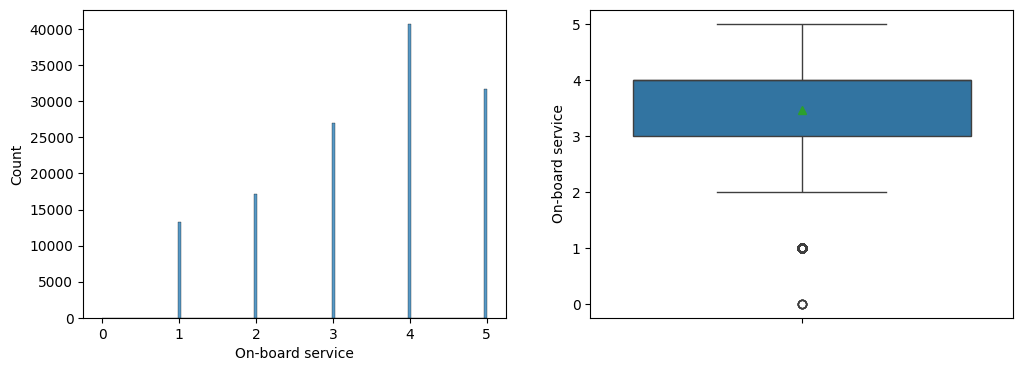

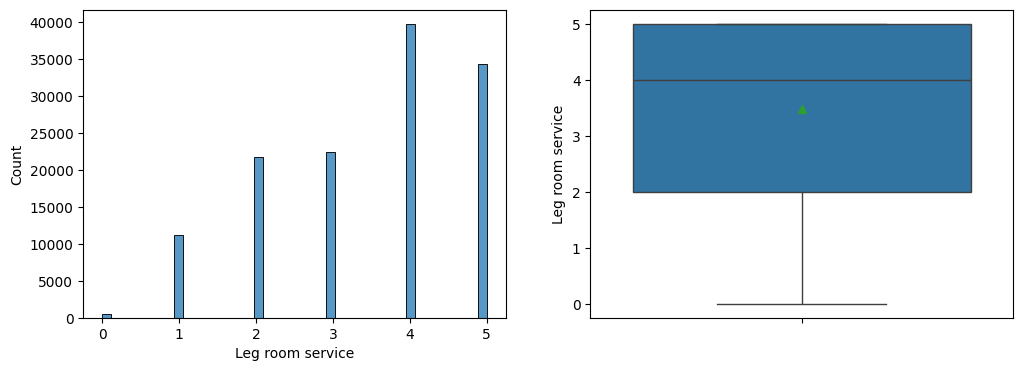

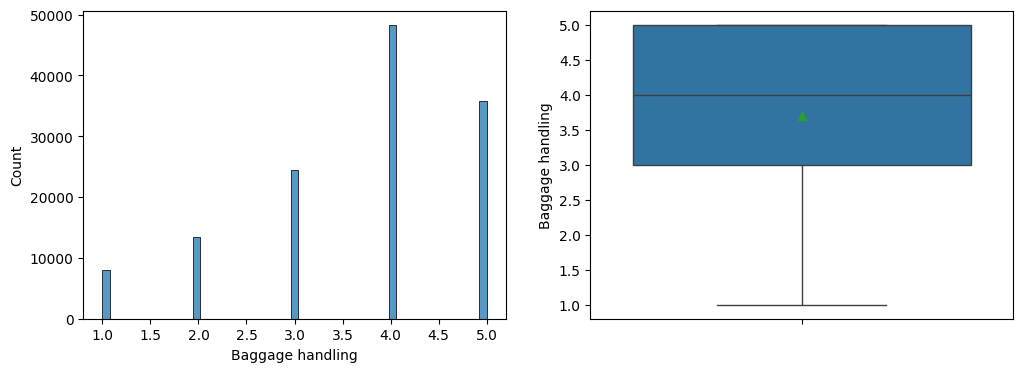

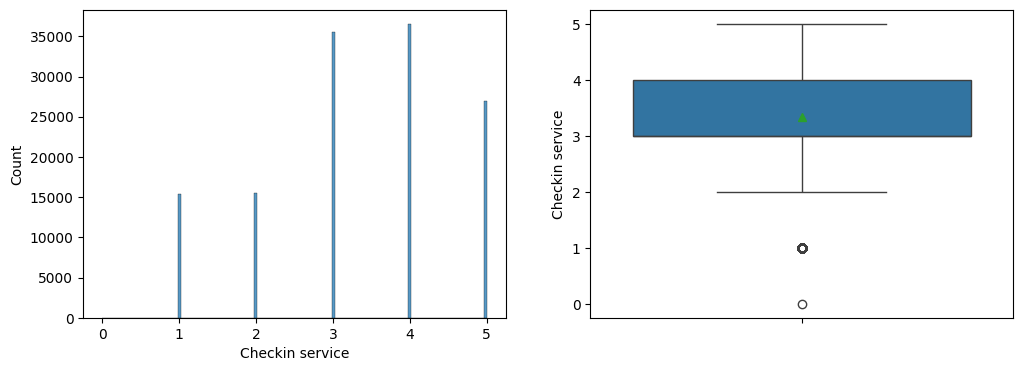

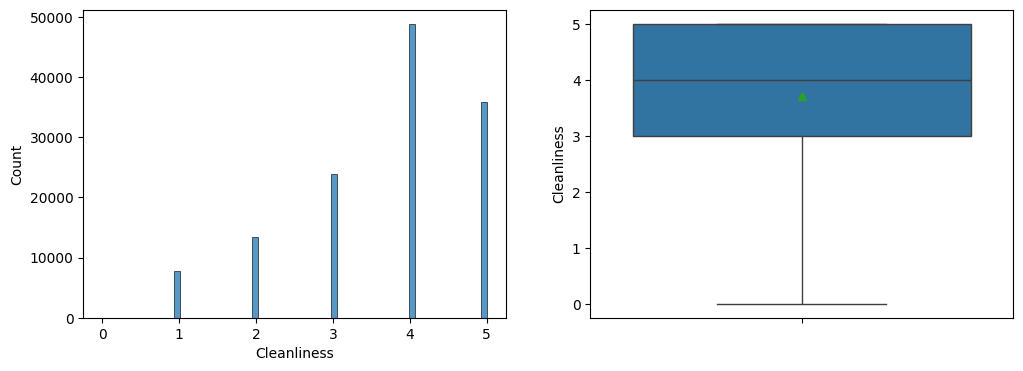

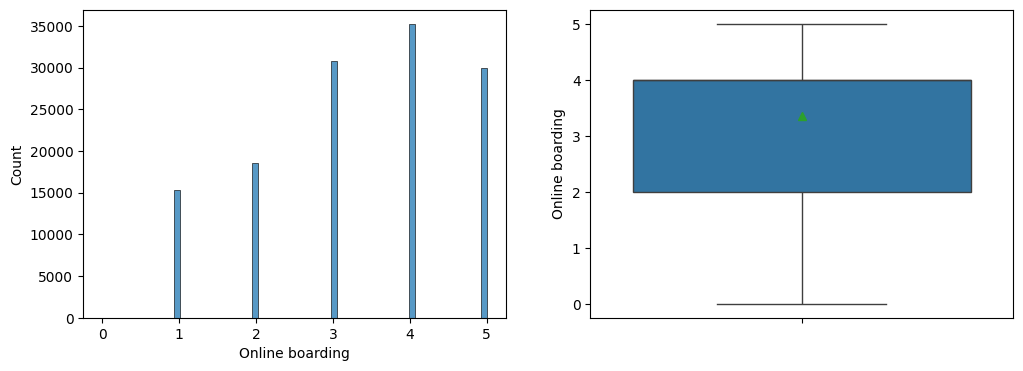

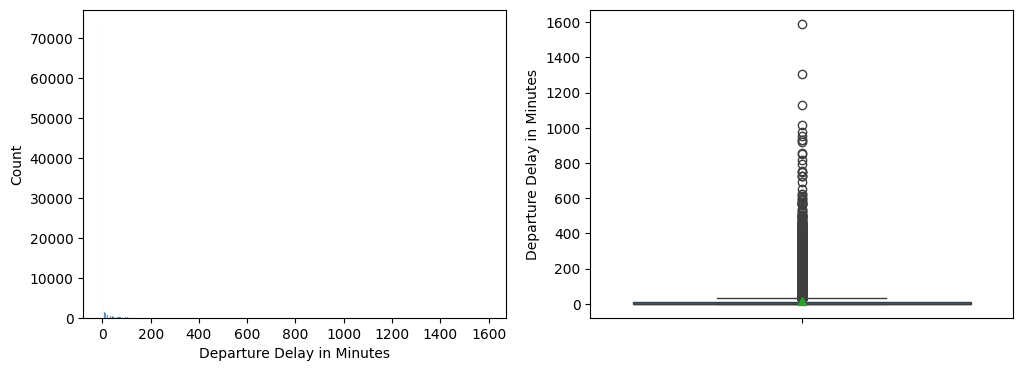

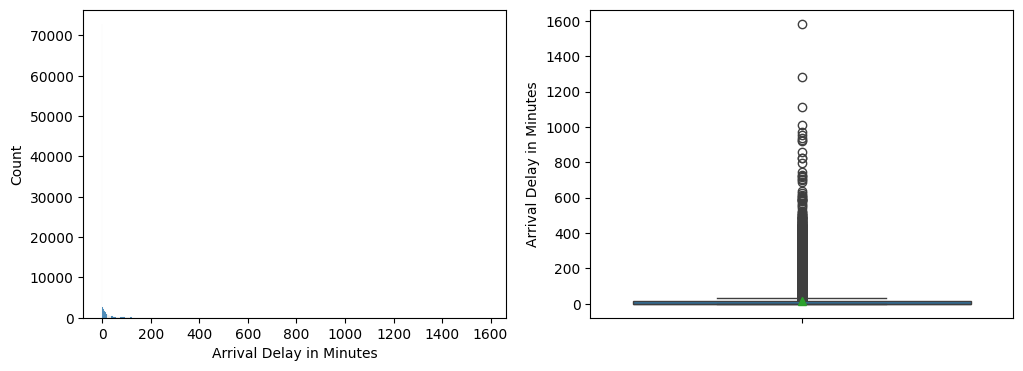

In [6]:
for col in df.select_dtypes('number').columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    sns.histplot(df[col], ax = axes[0])
    sns.boxplot(df[col], ax = axes[1], showmeans=True)
plt.show() 

### Identificatoins des correlations 

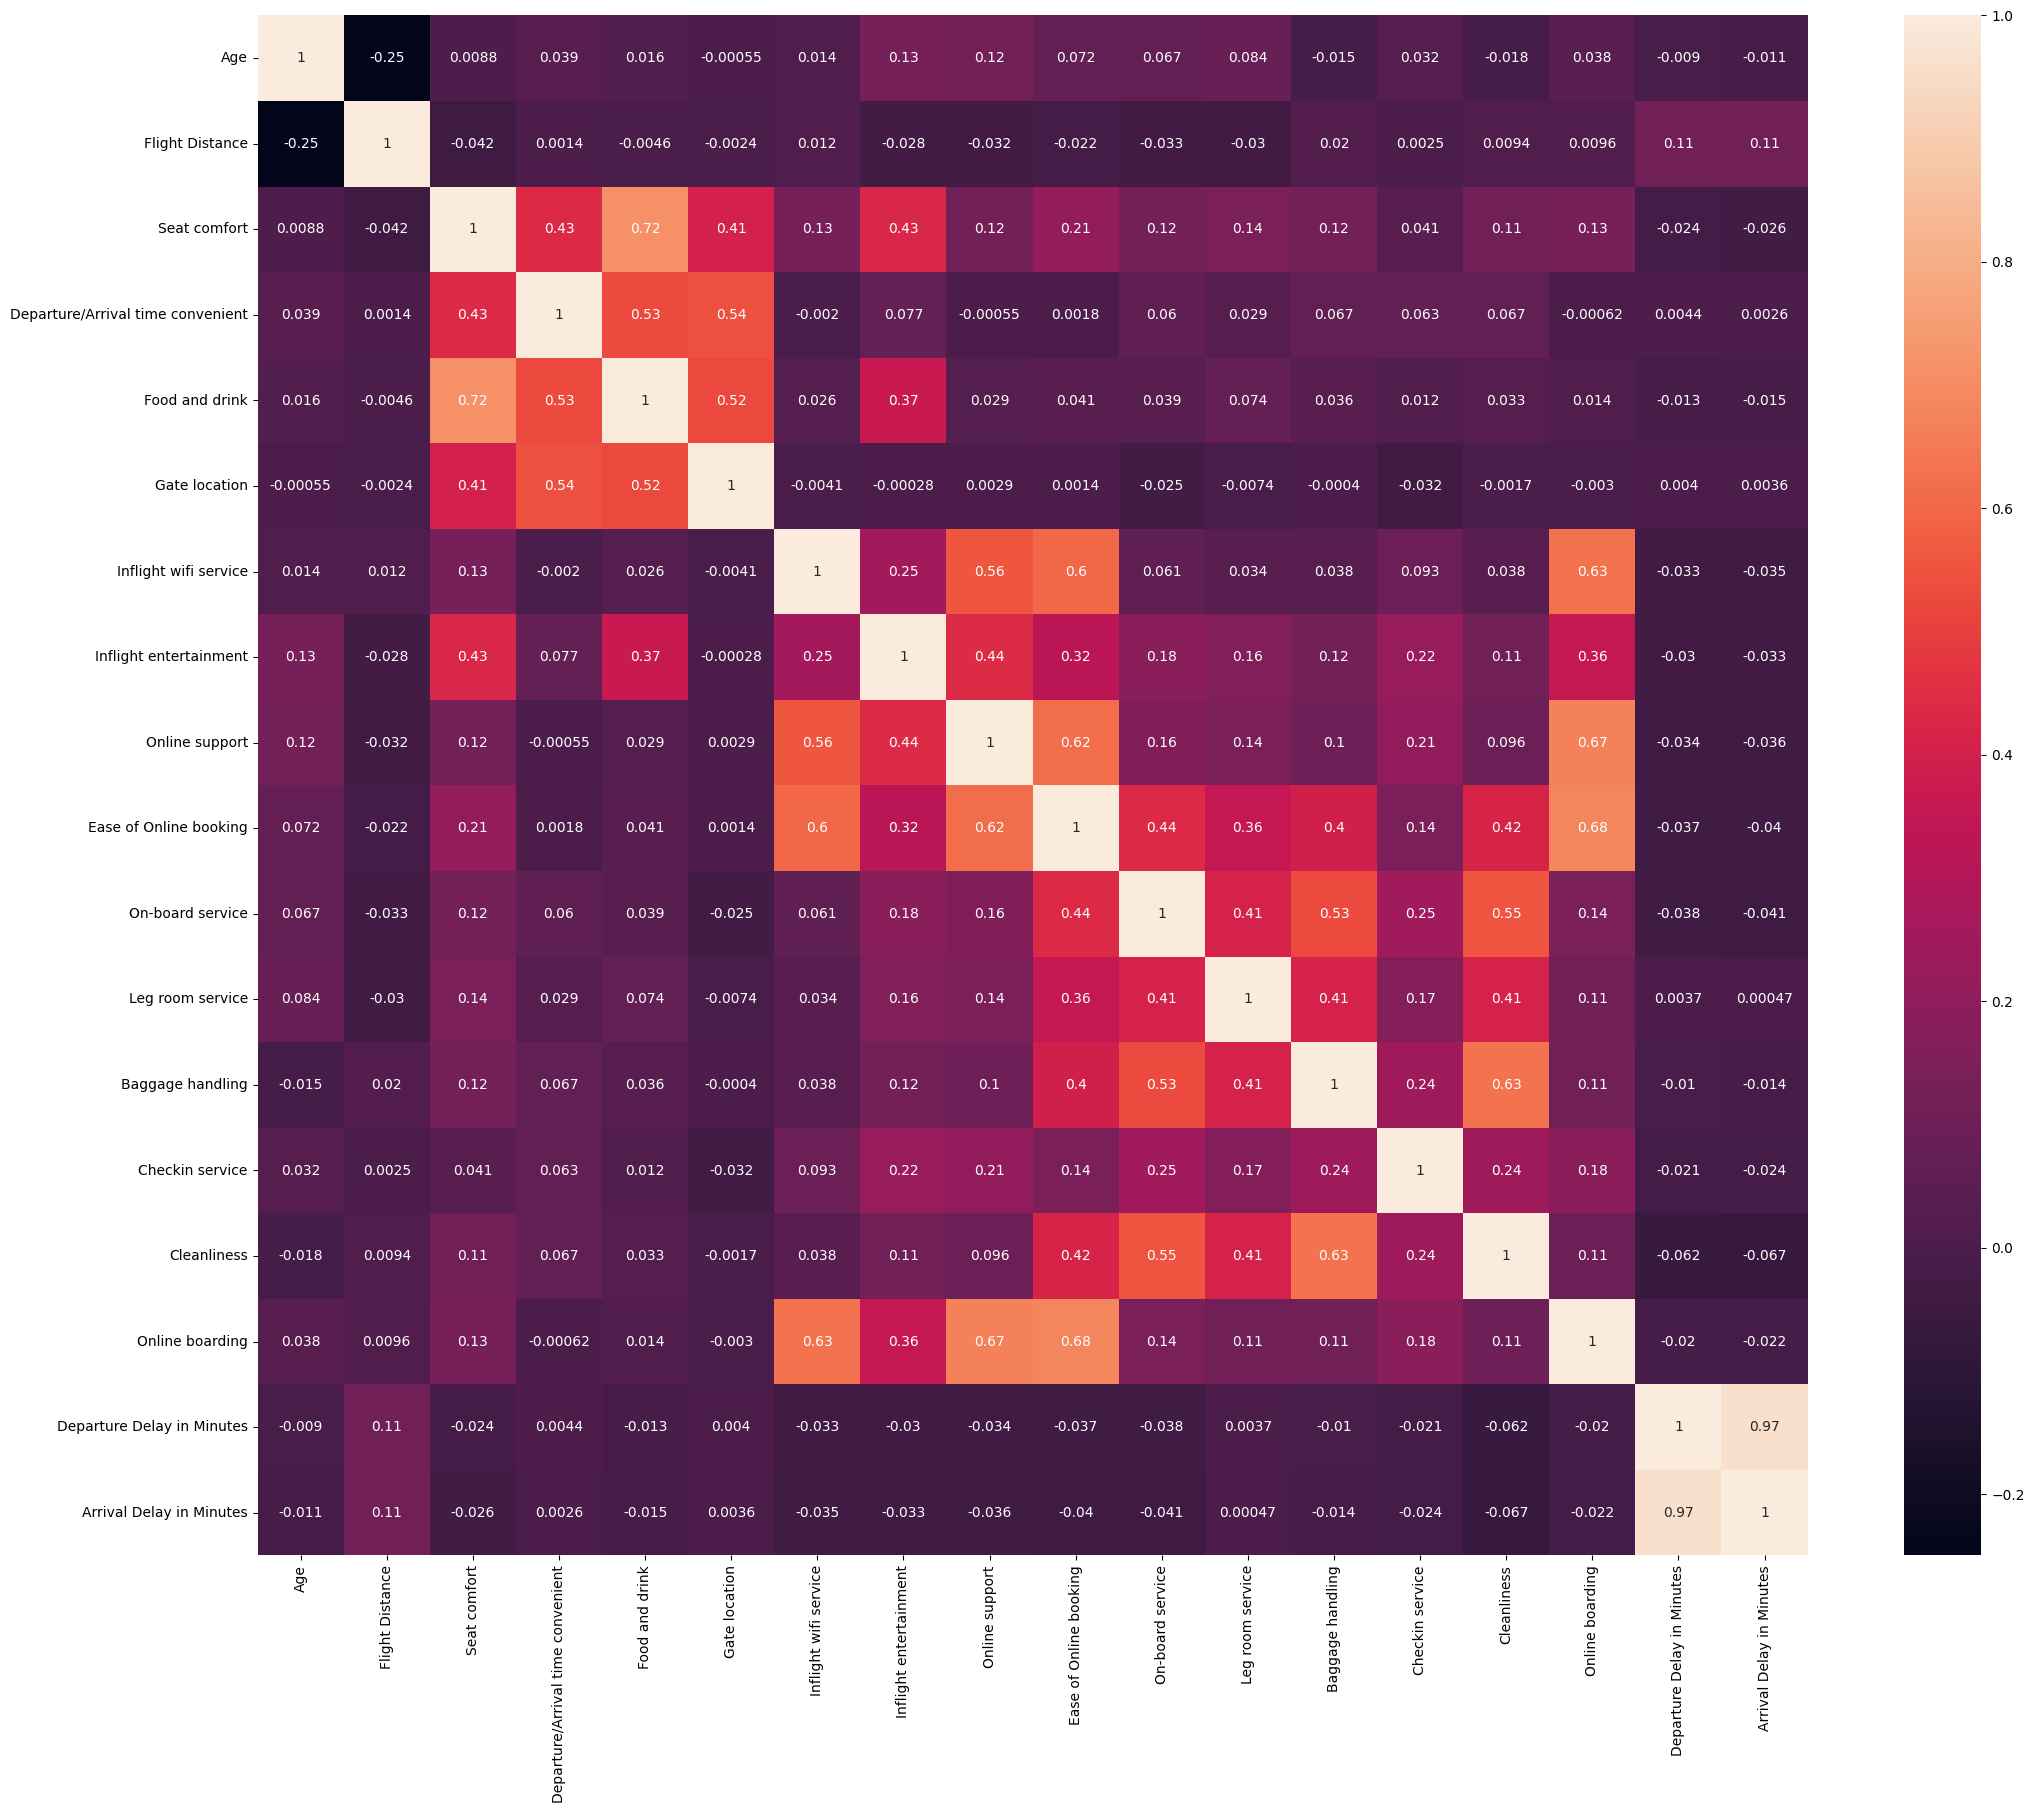

In [7]:
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(numeric_only=True), annot = True)
plt.show()

###  Visualiser la distribution des données pour les différentes classes(par exemple, satisfaction/non satisfaction)

<Axes: ylabel='satisfaction'>

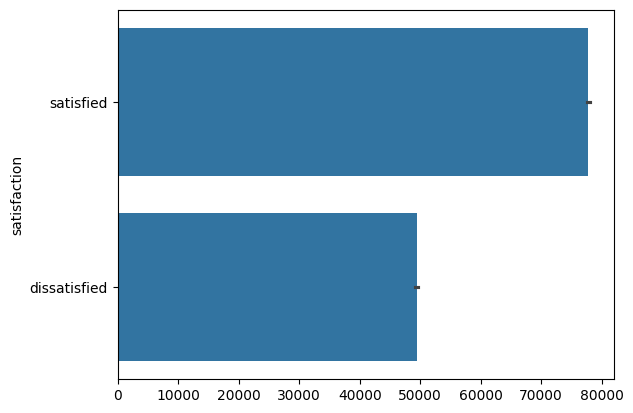

In [8]:
sns.barplot(df['satisfaction'])

In [9]:
df.groupby('satisfaction').describe()

Age                                                     \
                count       mean        std  min   25%   50%   75%   max   
satisfaction                                                               
dissatisfied  58793.0  37.466671  15.888110  7.0  25.0  36.0  49.0  85.0   
satisfied     71087.0  41.050051  14.250302  7.0  30.0  42.0  52.0  85.0   

             Flight Distance               ... Departure Delay in Minutes  \
                       count         mean  ...                        75%   
satisfaction                               ...                              
dissatisfied         58793.0  2025.709234  ...                       16.0   
satisfied            71087.0  1944.770281  ...                        9.0   

                     Arrival Delay in Minutes                                  \
                 max                    count       mean        std  min  25%   
satisfaction                                                                    
dissatisfied  1592.0                  58605.0  18.504599  43.848751  0.0  0.0   
satisfied     1305.0                  70882.0  12.268883  33.100908  0.0  0.0   

                                 
              50%   75%     max  
satisfaction                     
dissatisfied  0.0  18.0  1584.0  
satisfied     0.0   9.0  1280.0  

[2 rows x 144 columns]

### 2. Prétraitement des Données

Dans ce cas de preprocessing, nous allons utiliser les pipelines, mais avant cela traitons d'abord les valeurs aberrantes

In [10]:
def impute_outliers(data, colname): 
    q1 = np.percentile(data[colname], 25)
    q3 = np.percentile(data[colname], 75) 

    lower_bound = q1 - 1.5*(q3 - q1)
    upper_bound = q3 + 1.5*(q3 - q1)

    data.loc[(data[colname] <= lower_bound), colname] = lower_bound
    data.loc[(data[colname] >= upper_bound), colname] = upper_bound

In [12]:
for colname in df.select_dtypes('number').columns:
    impute_outliers(df, colname)

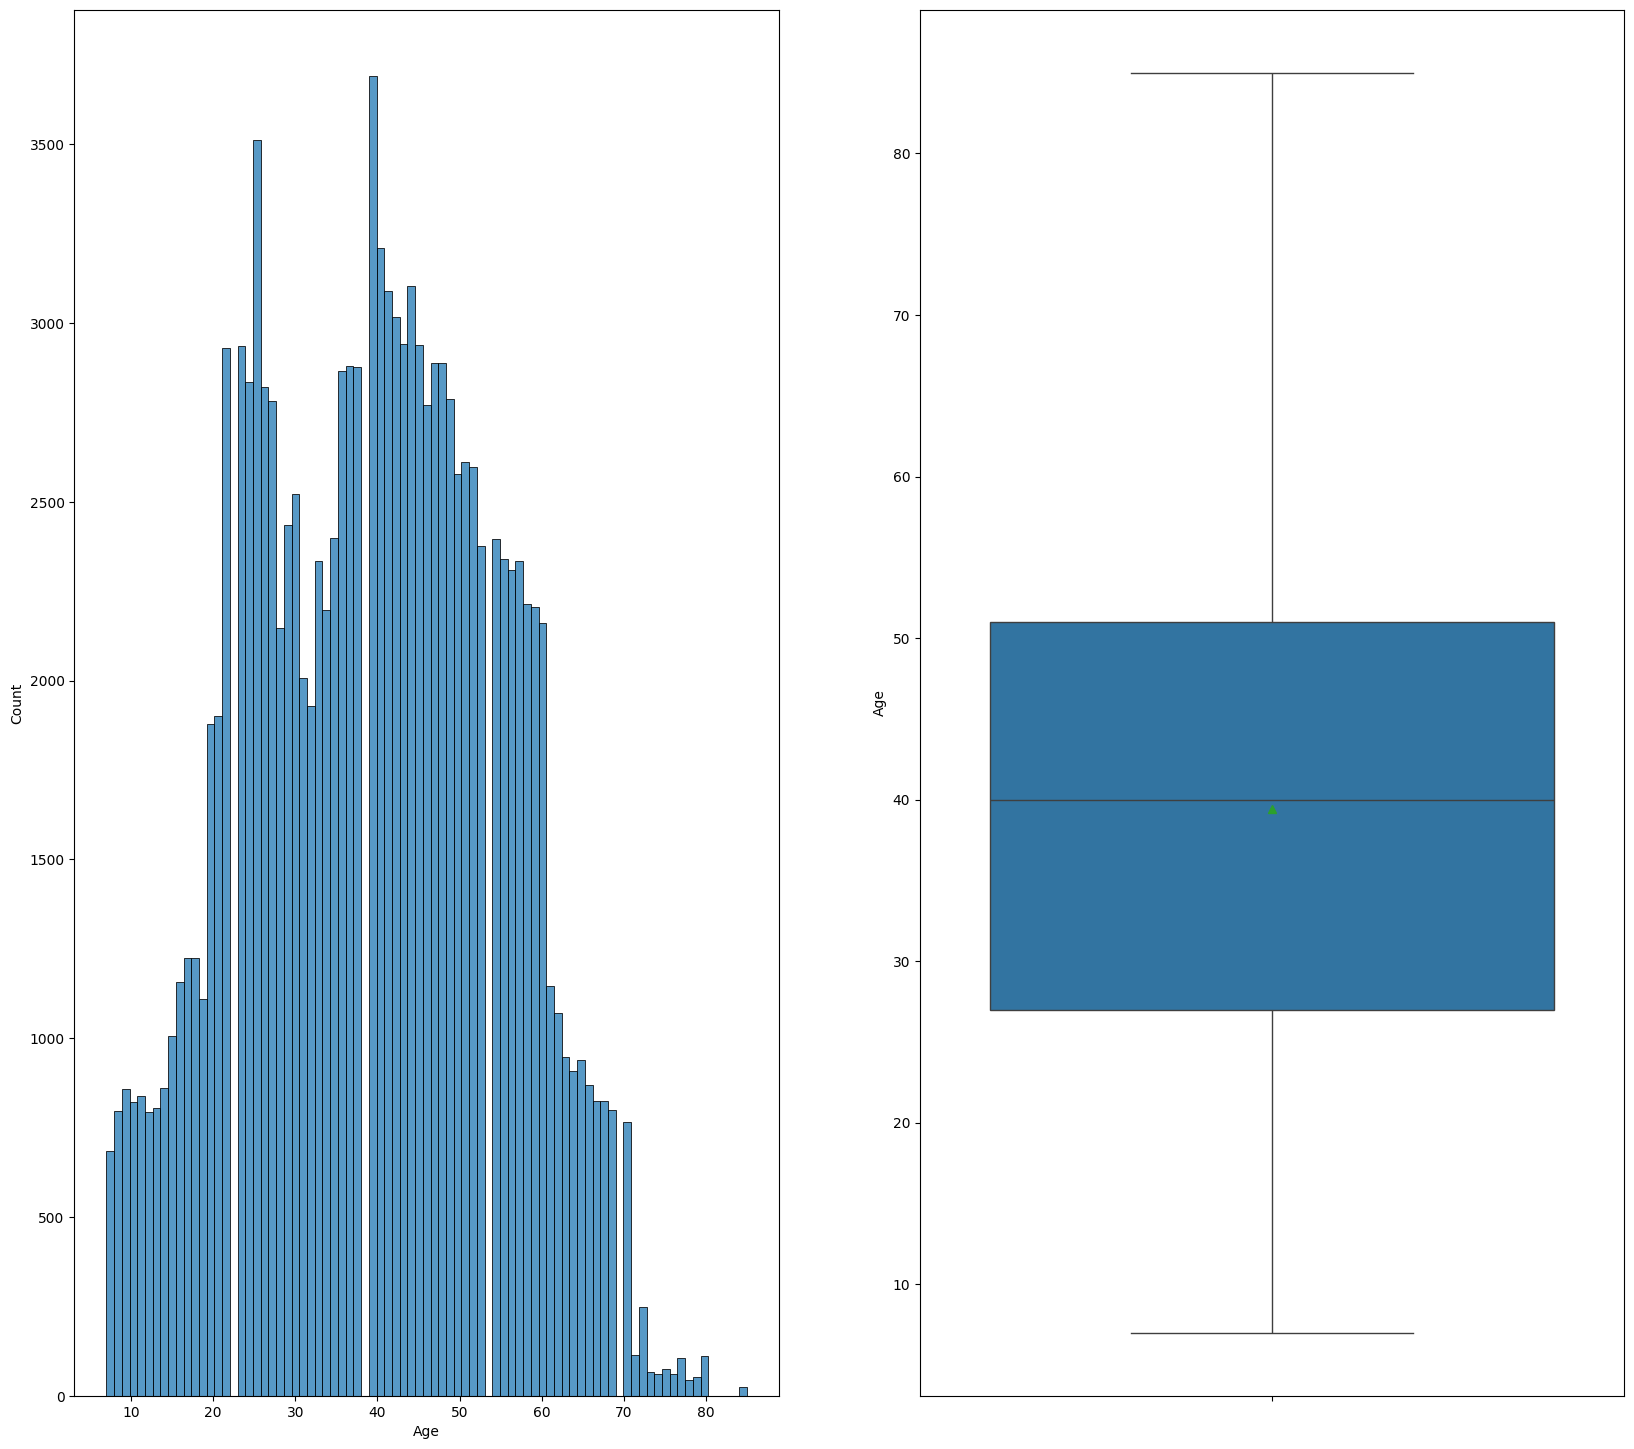

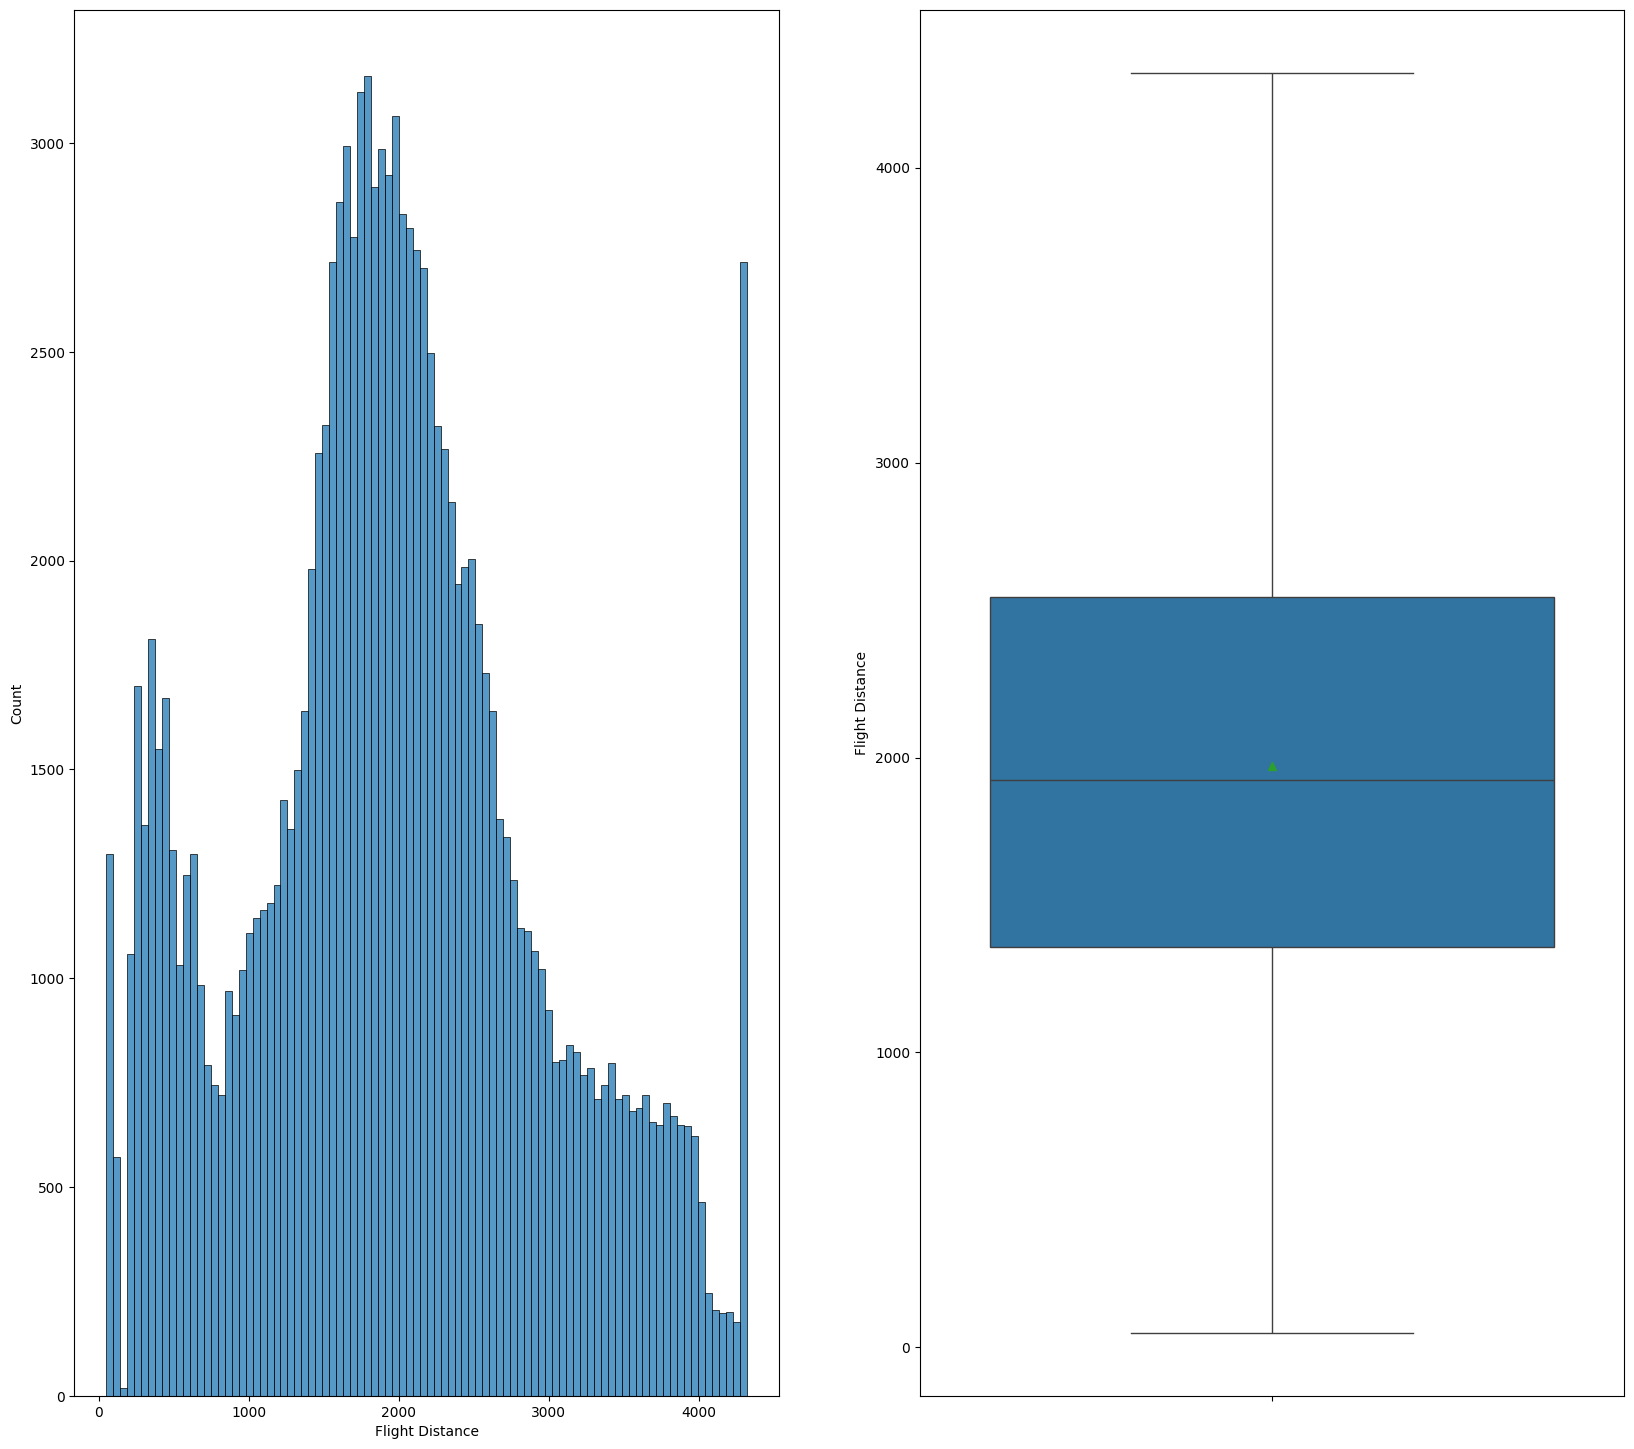

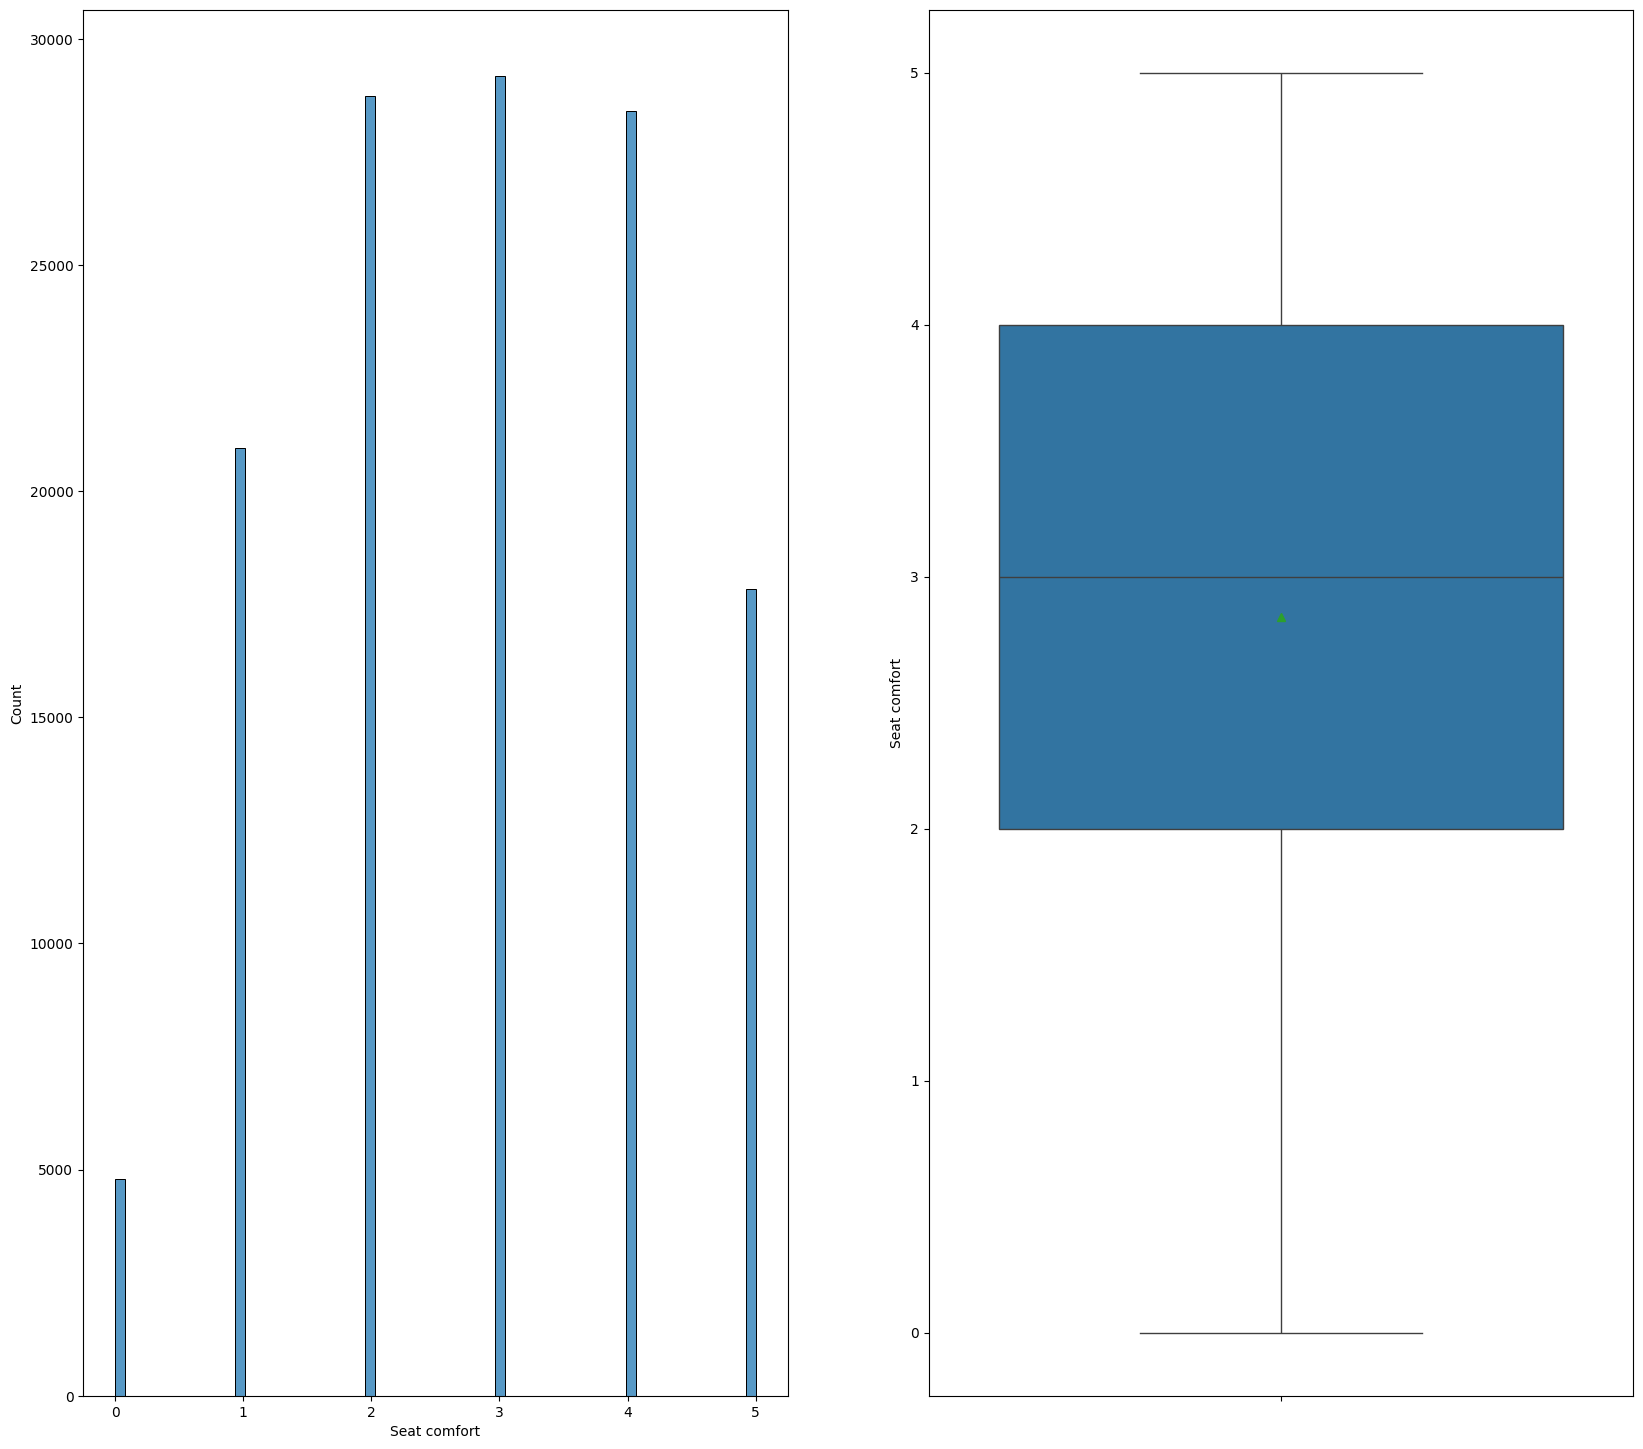

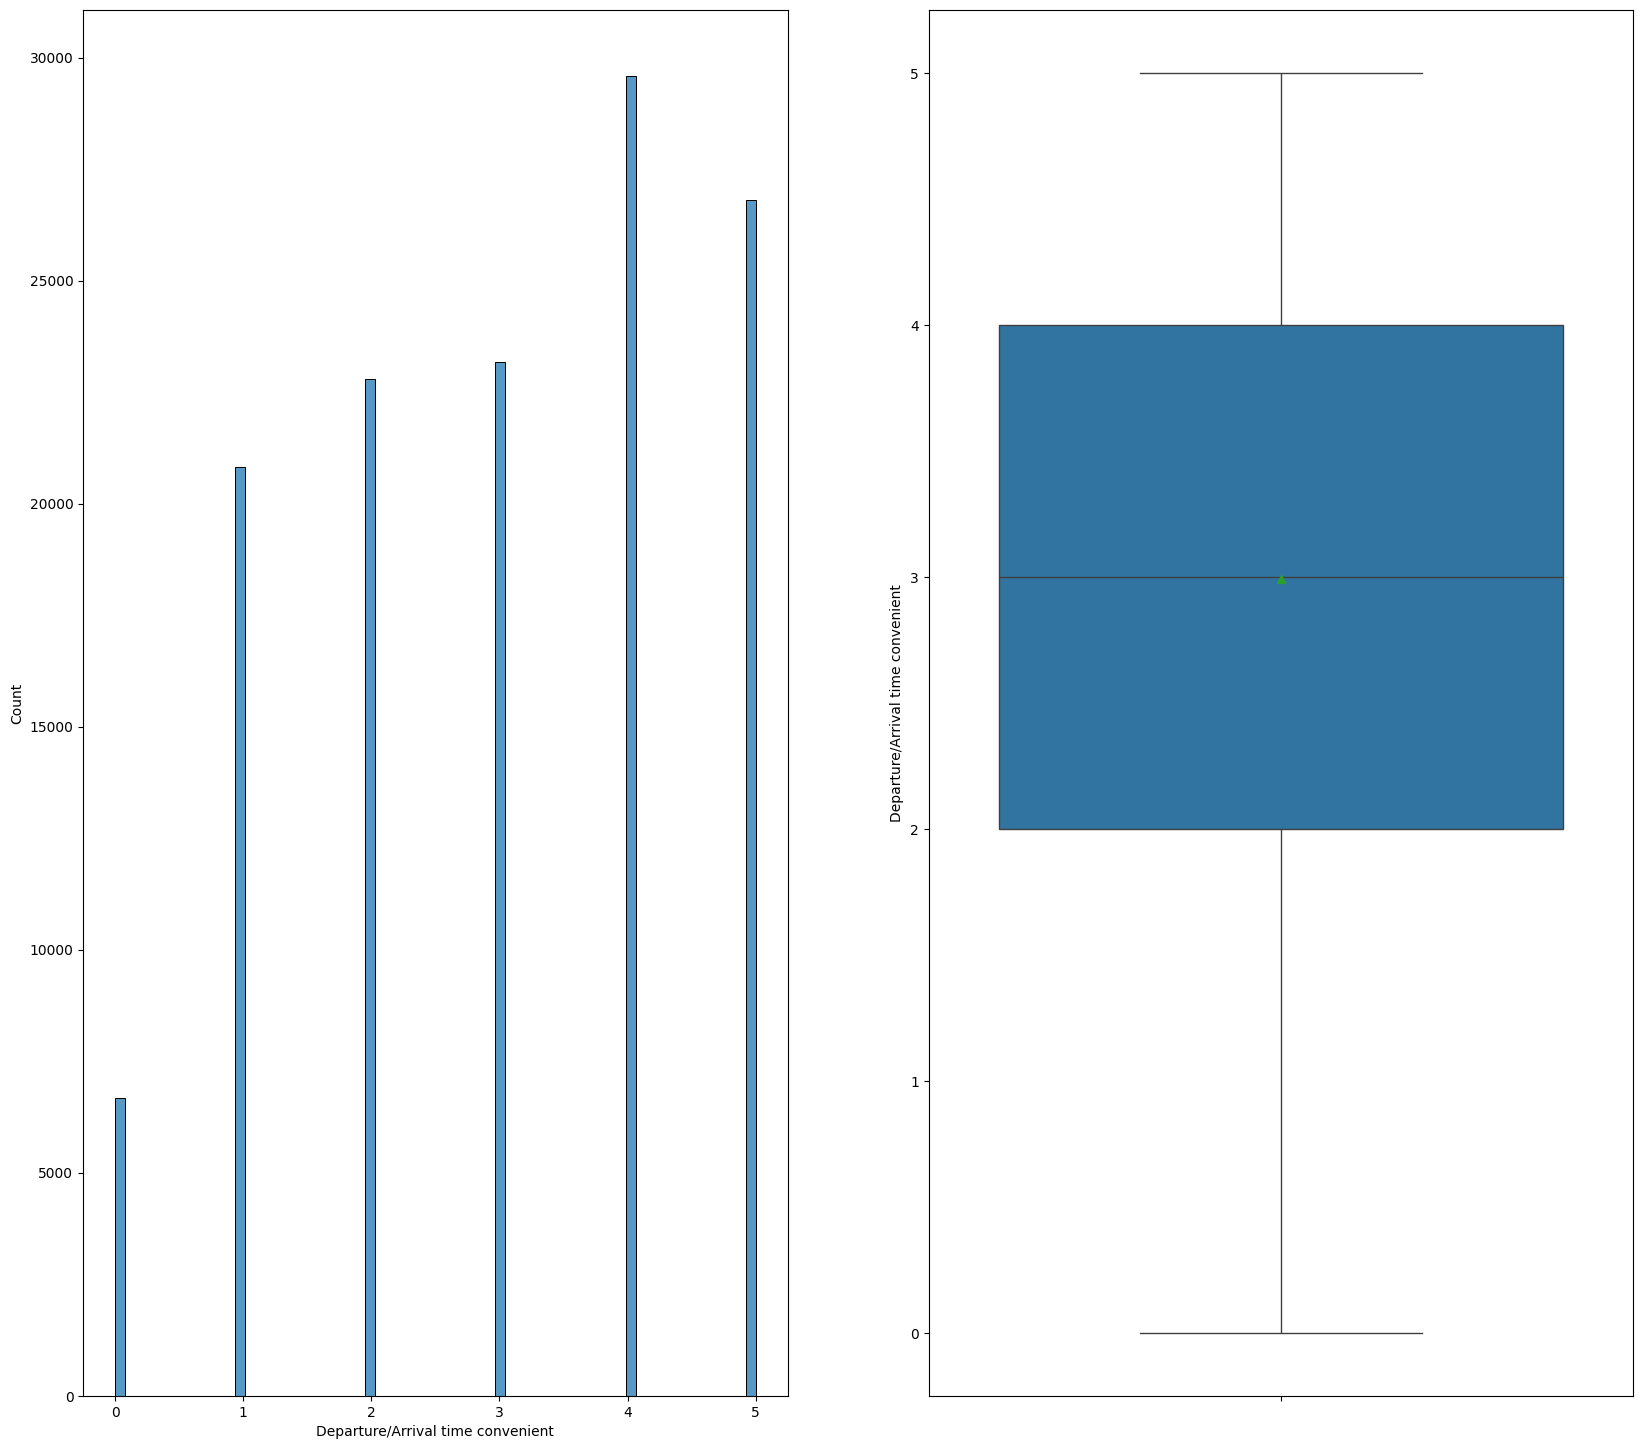

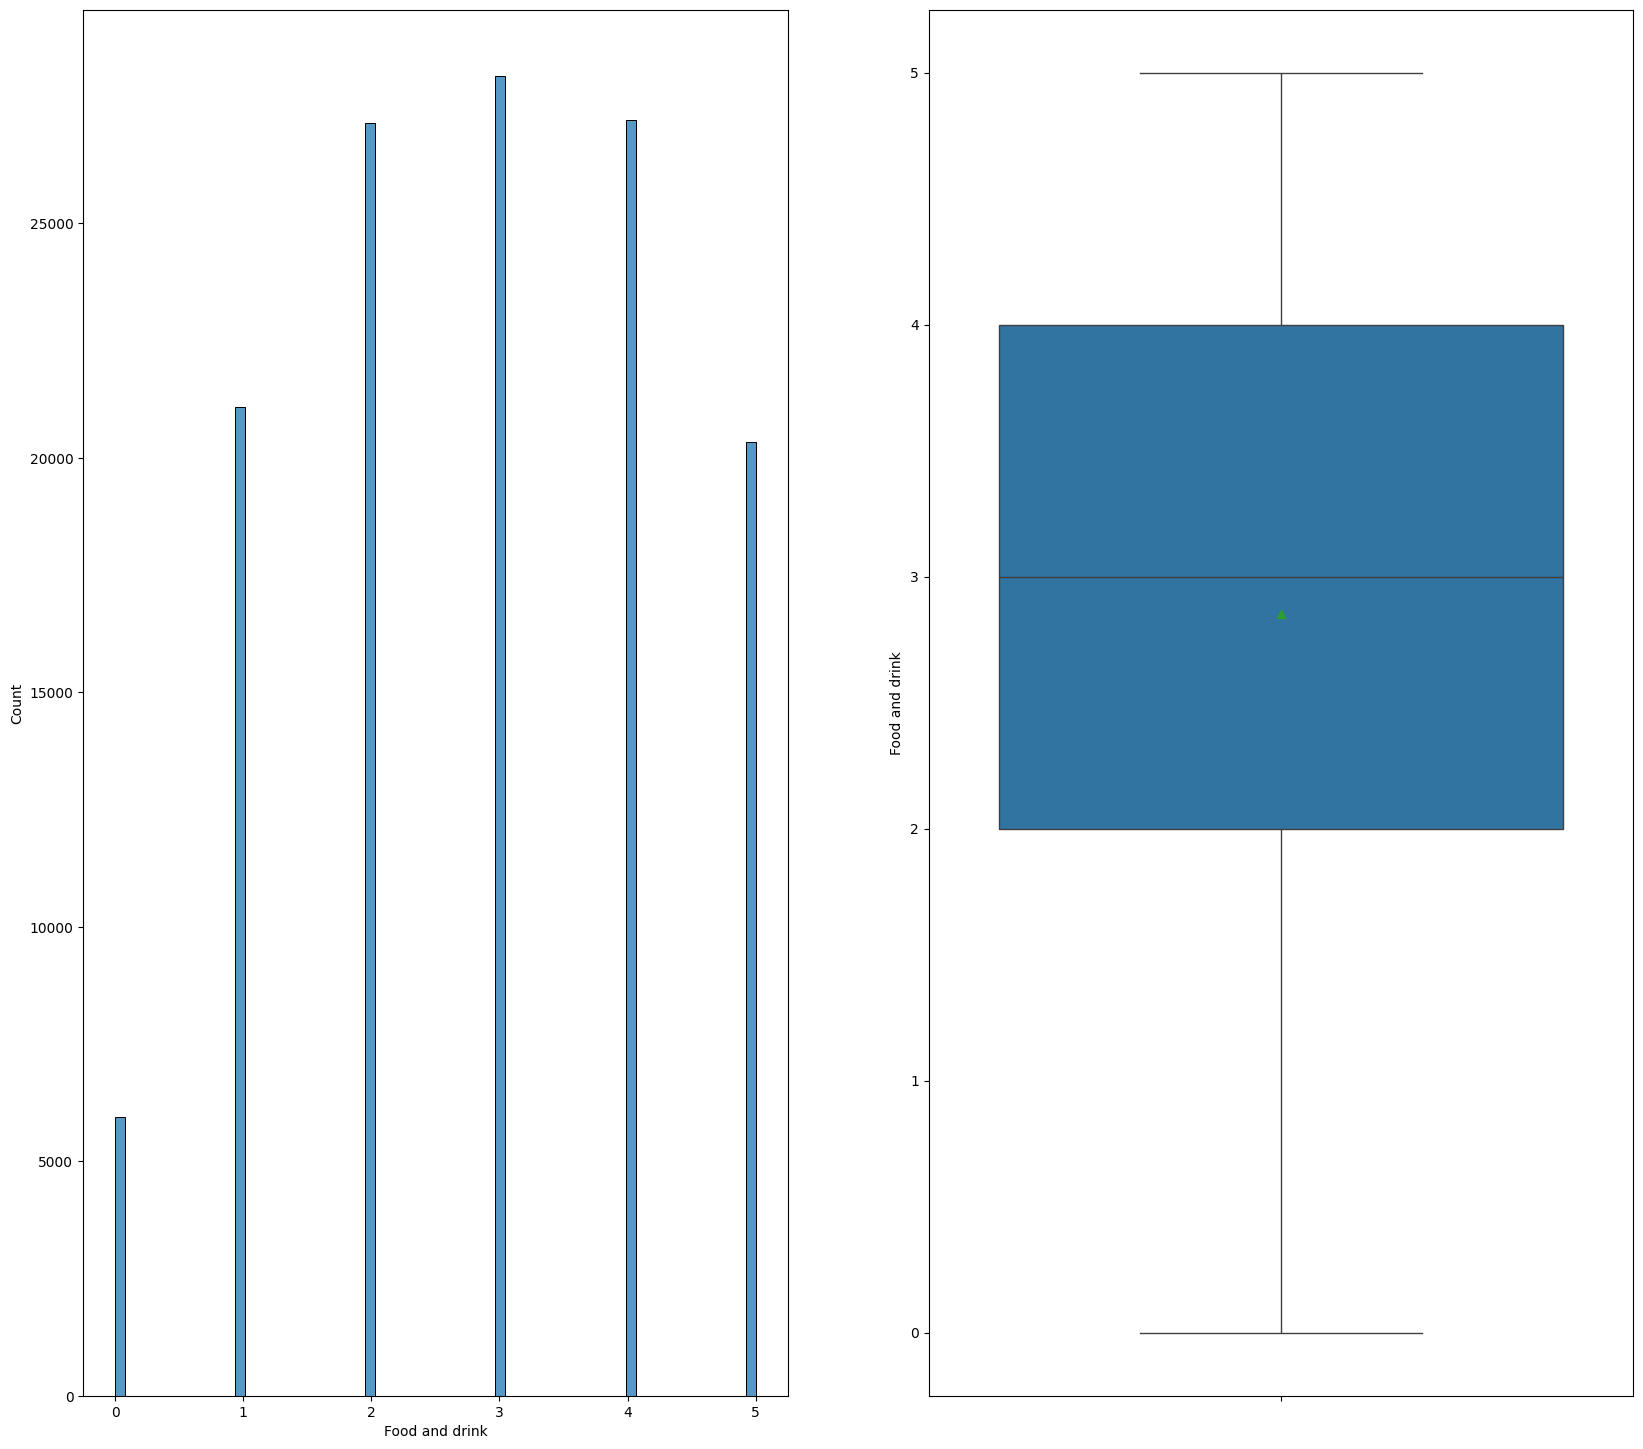

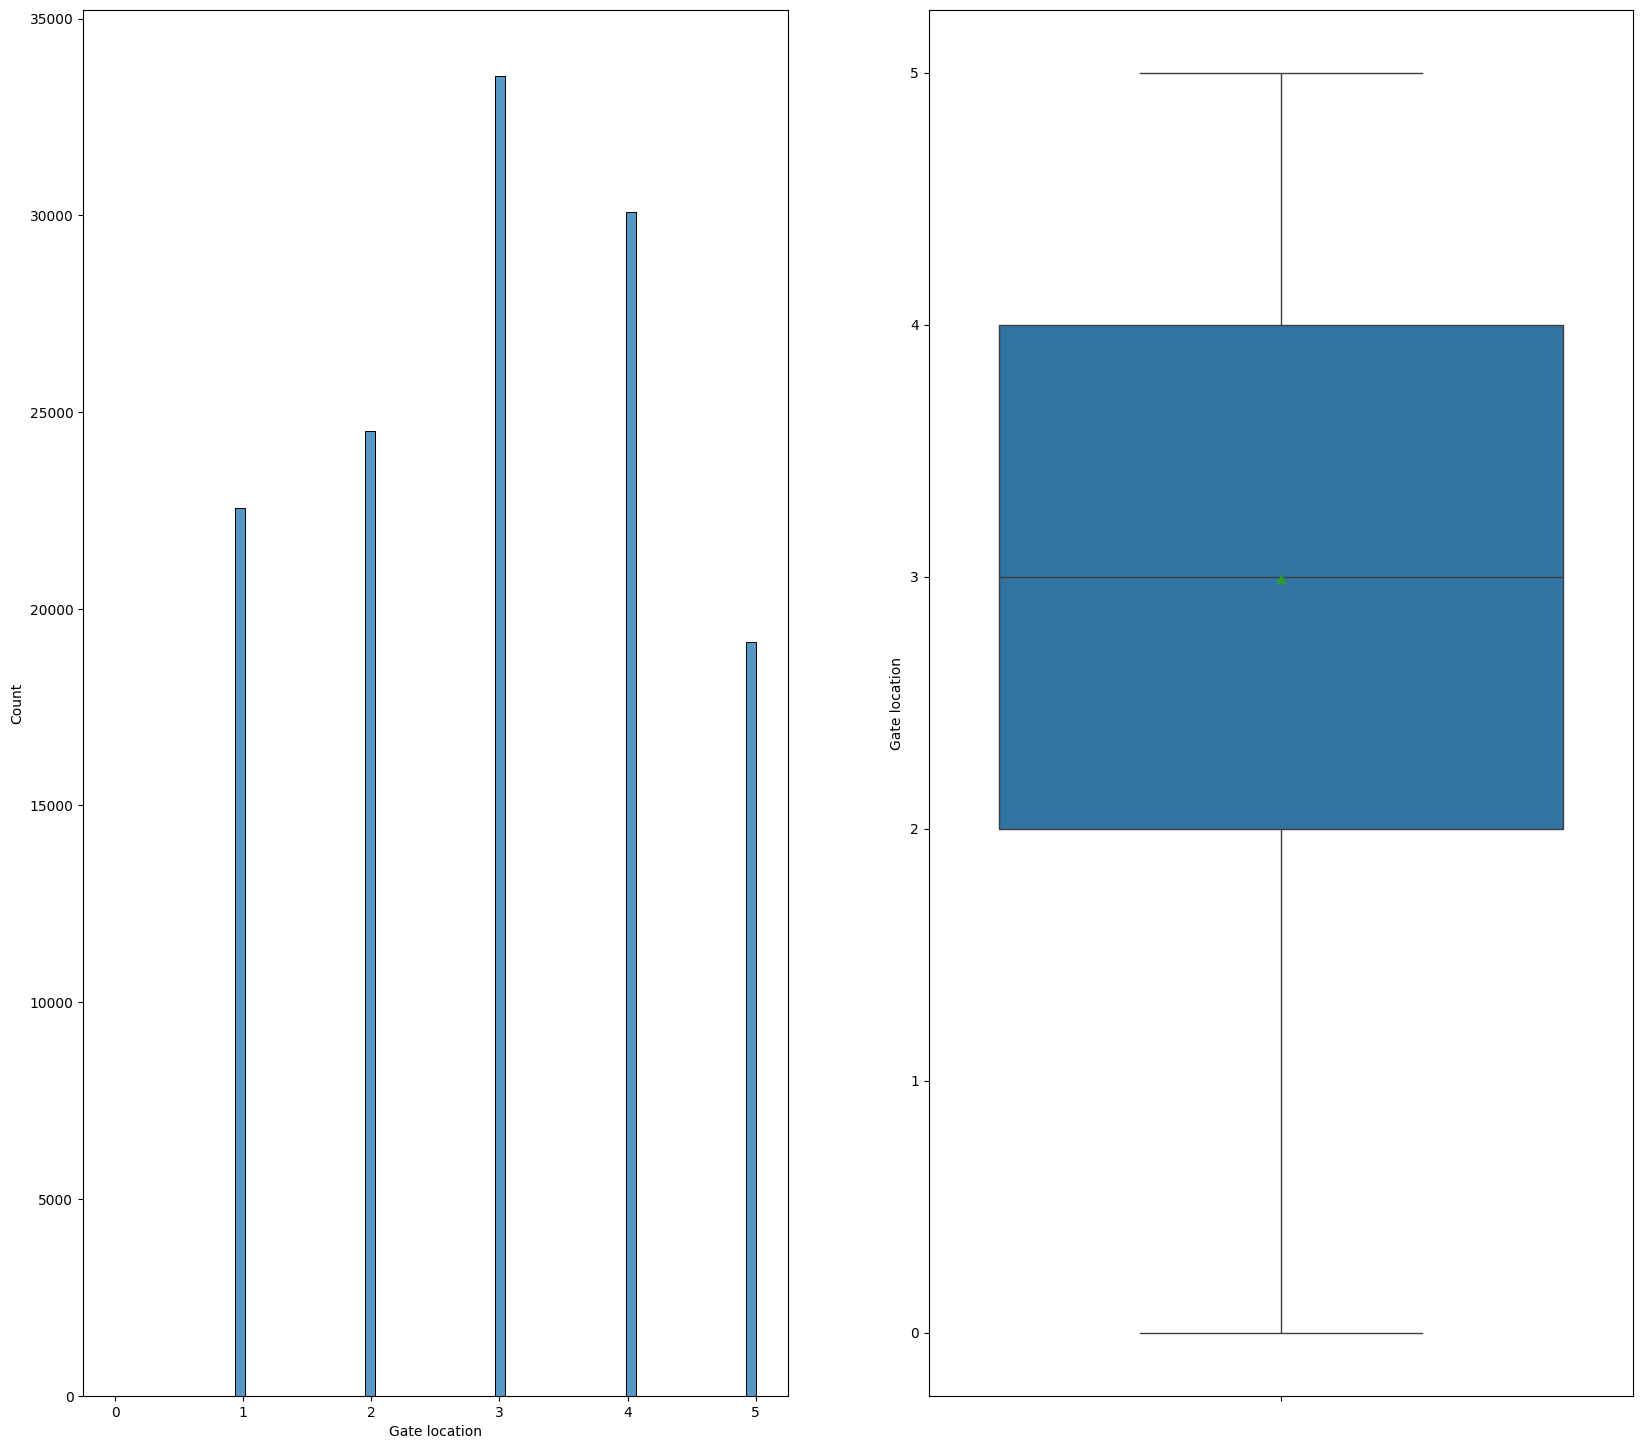

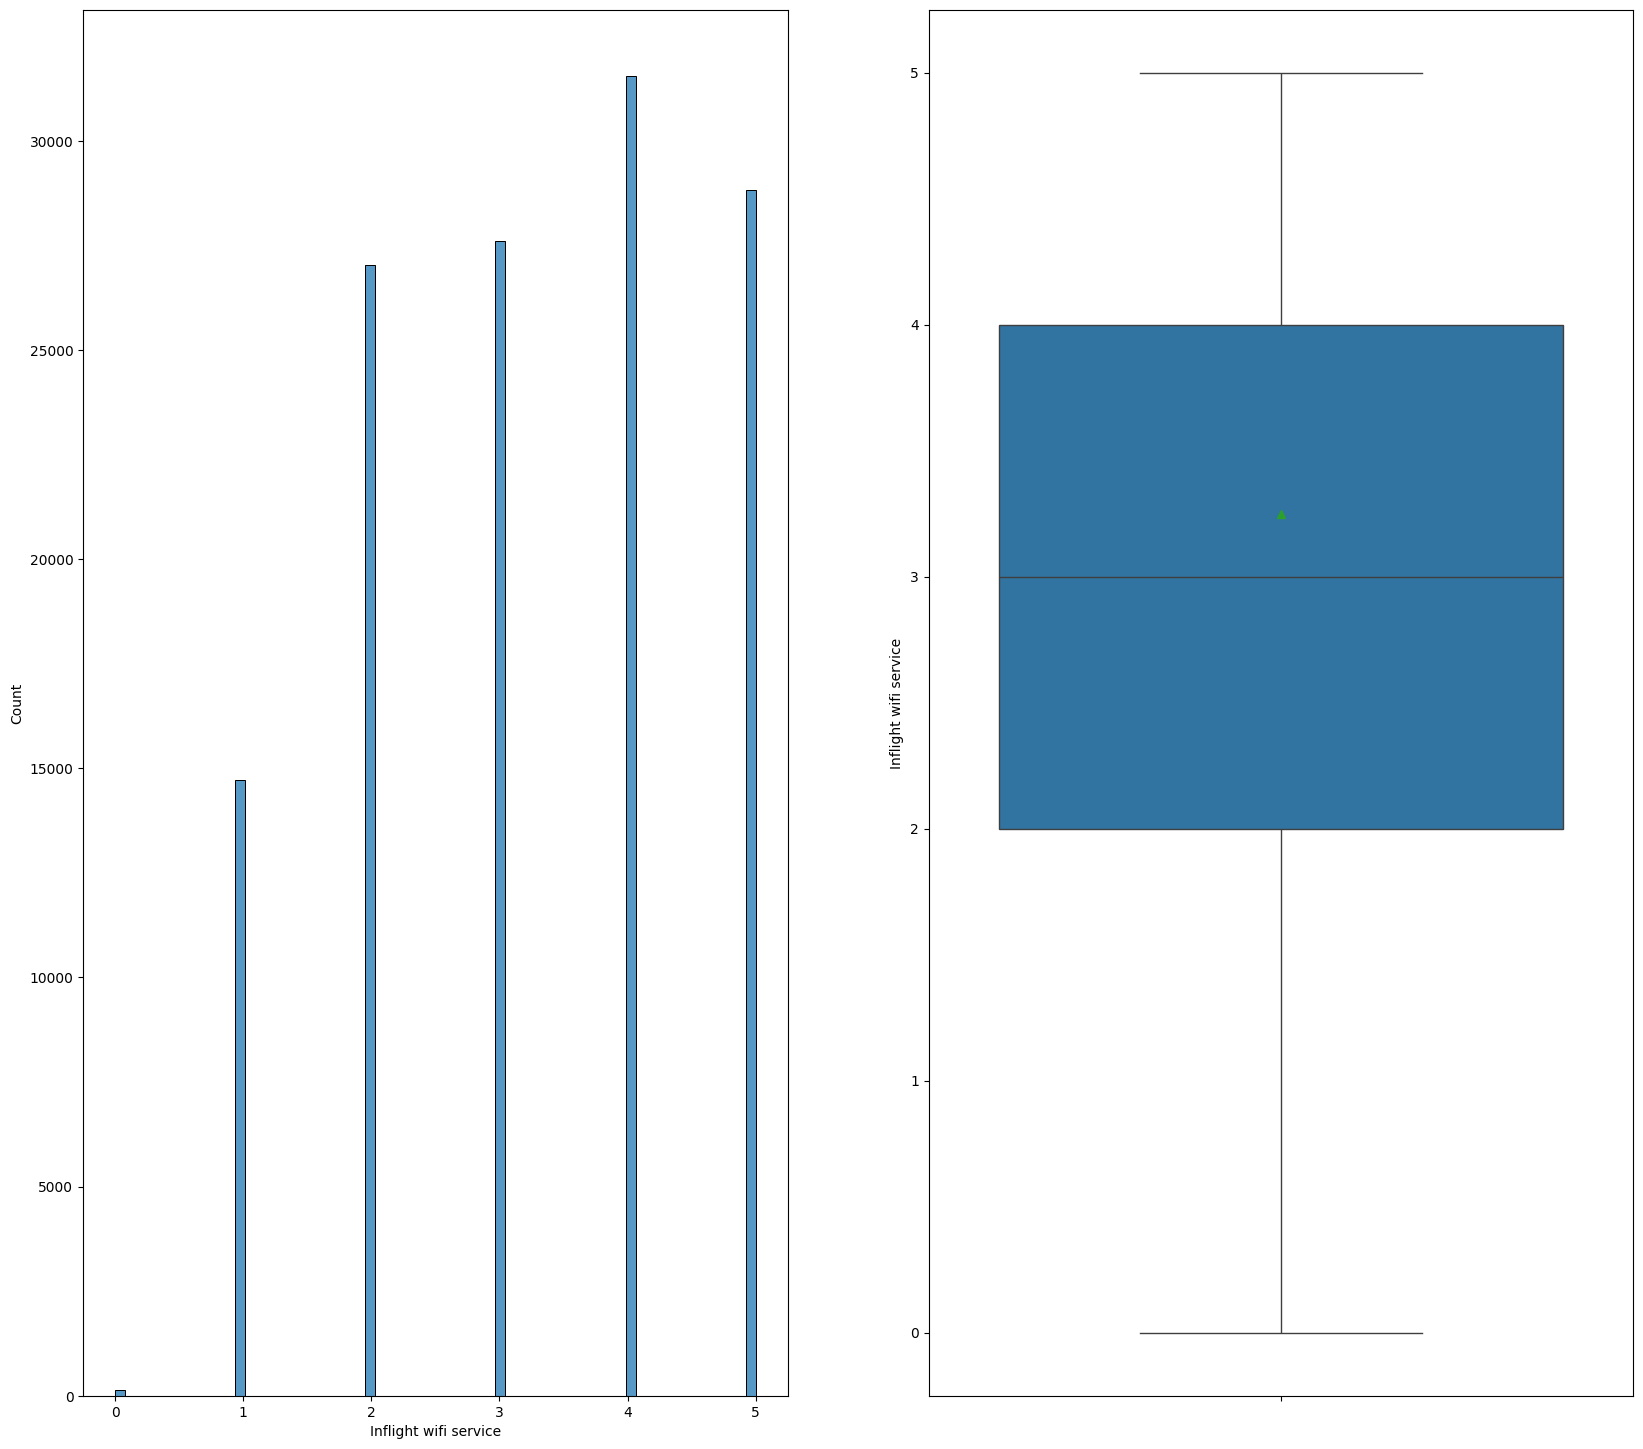

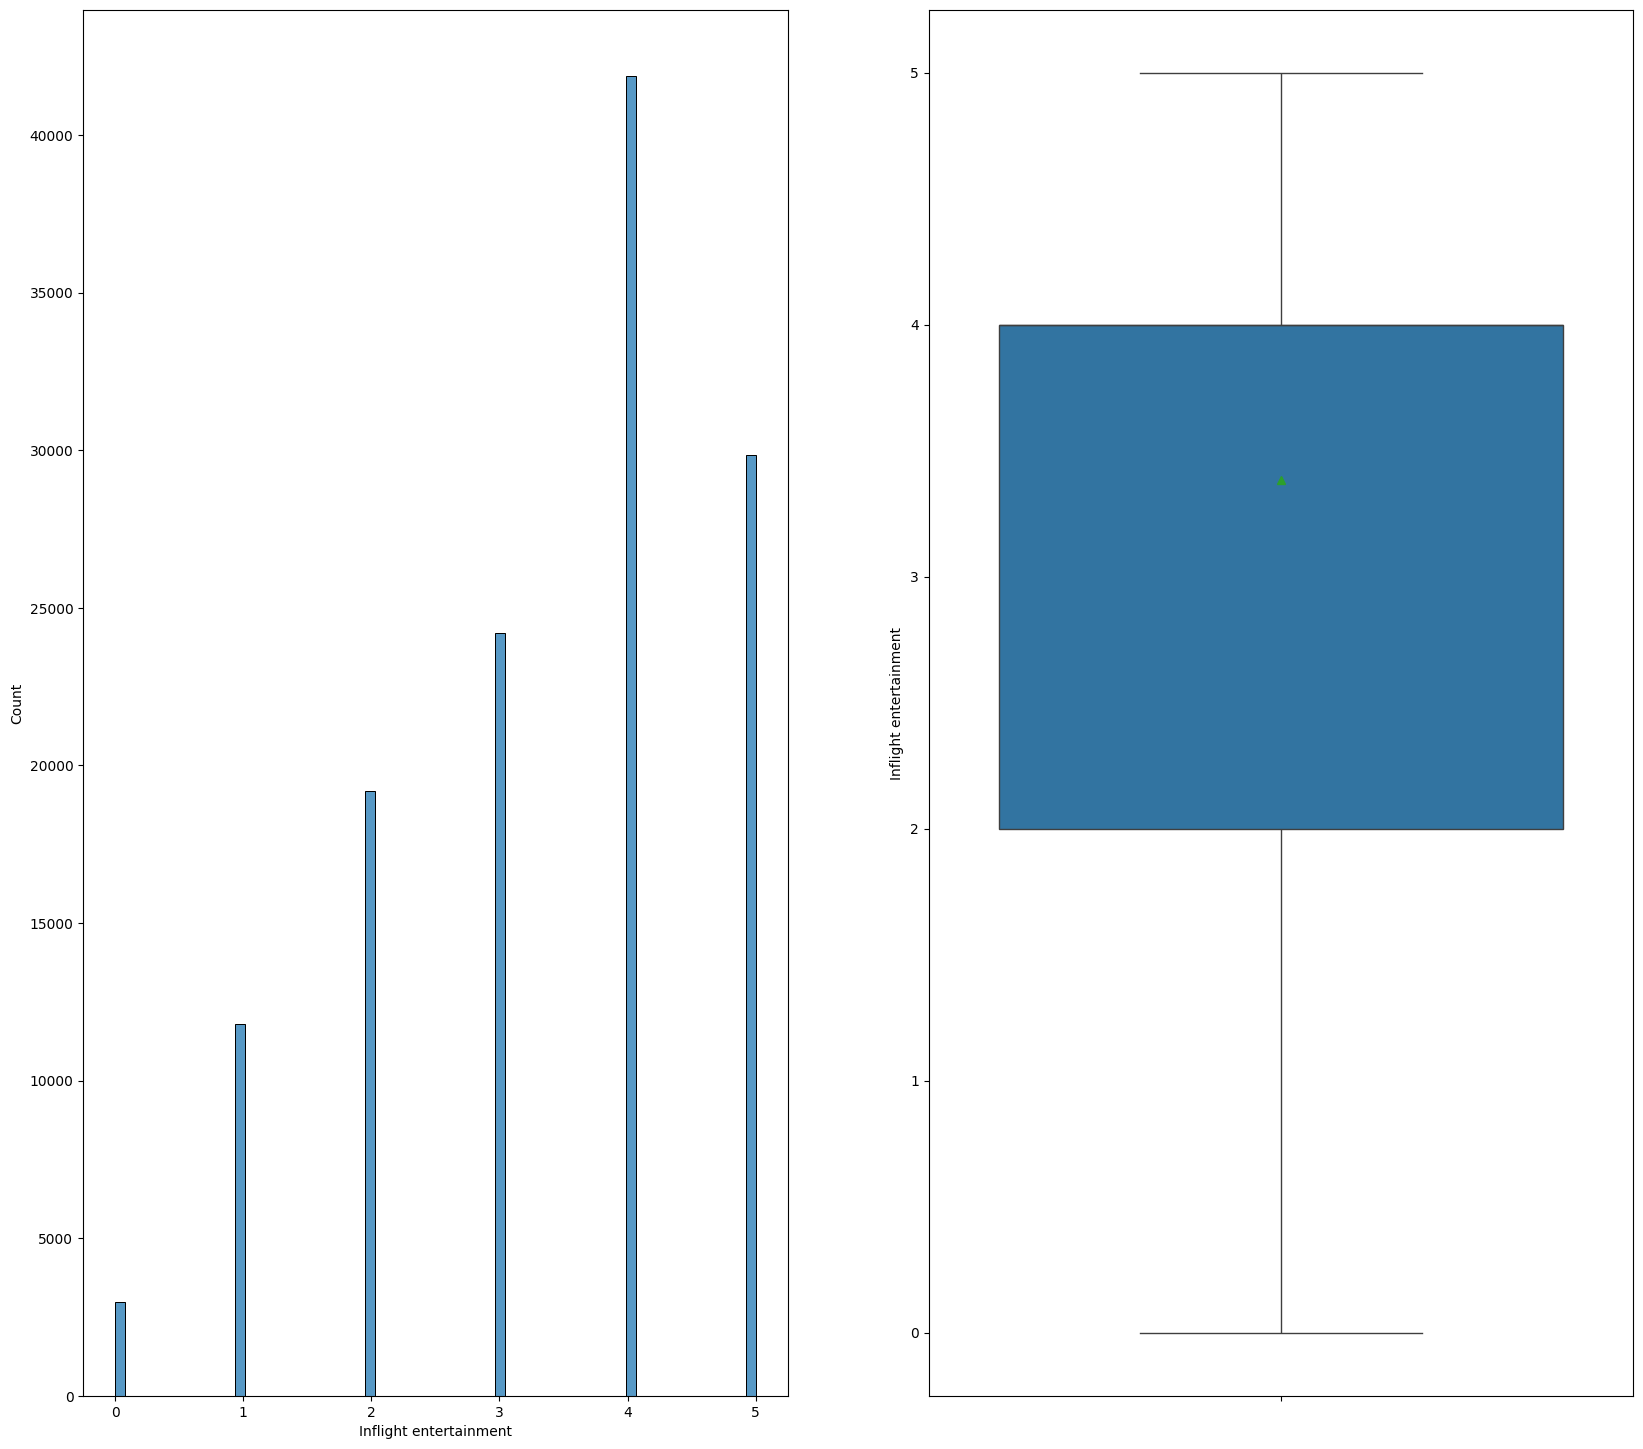

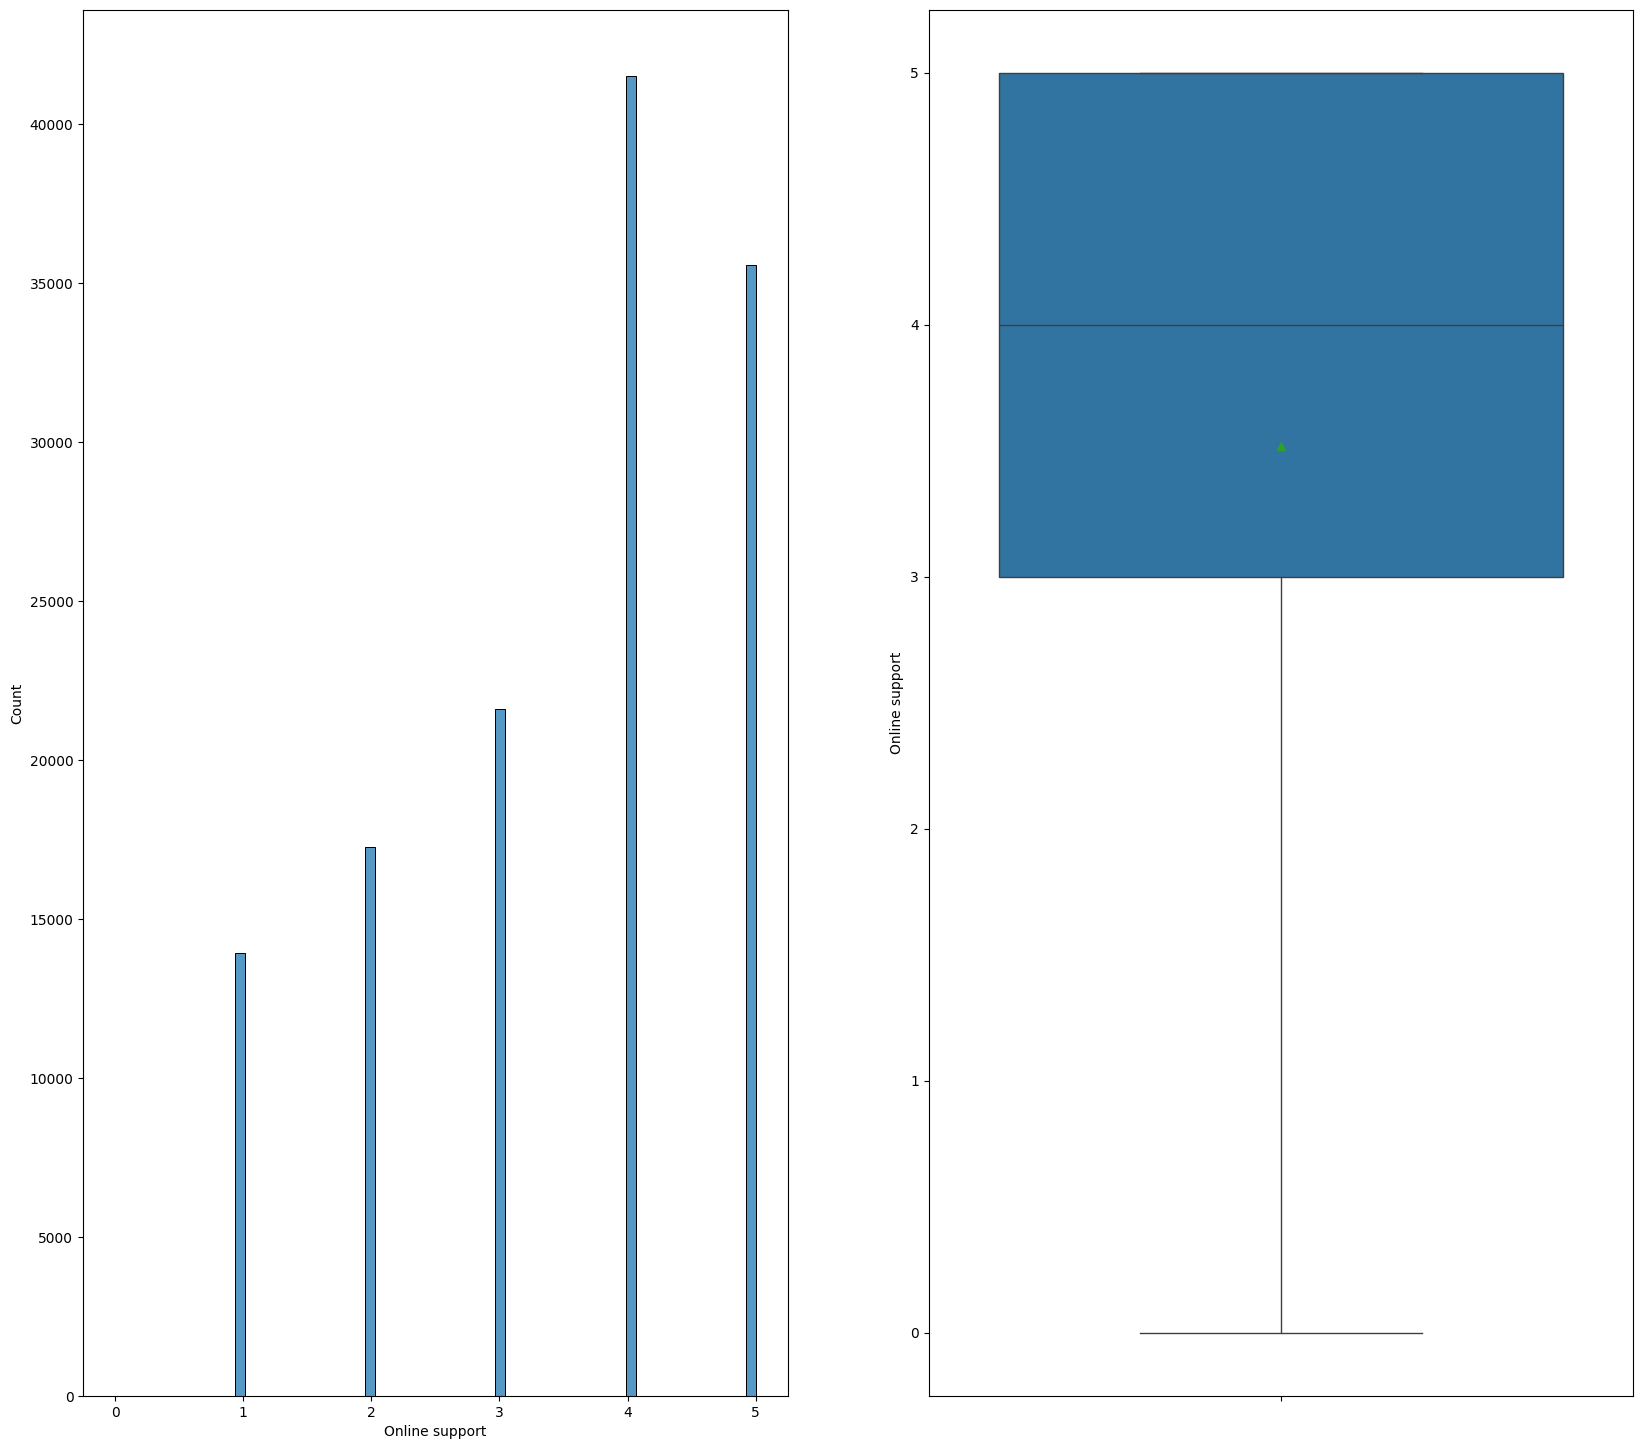

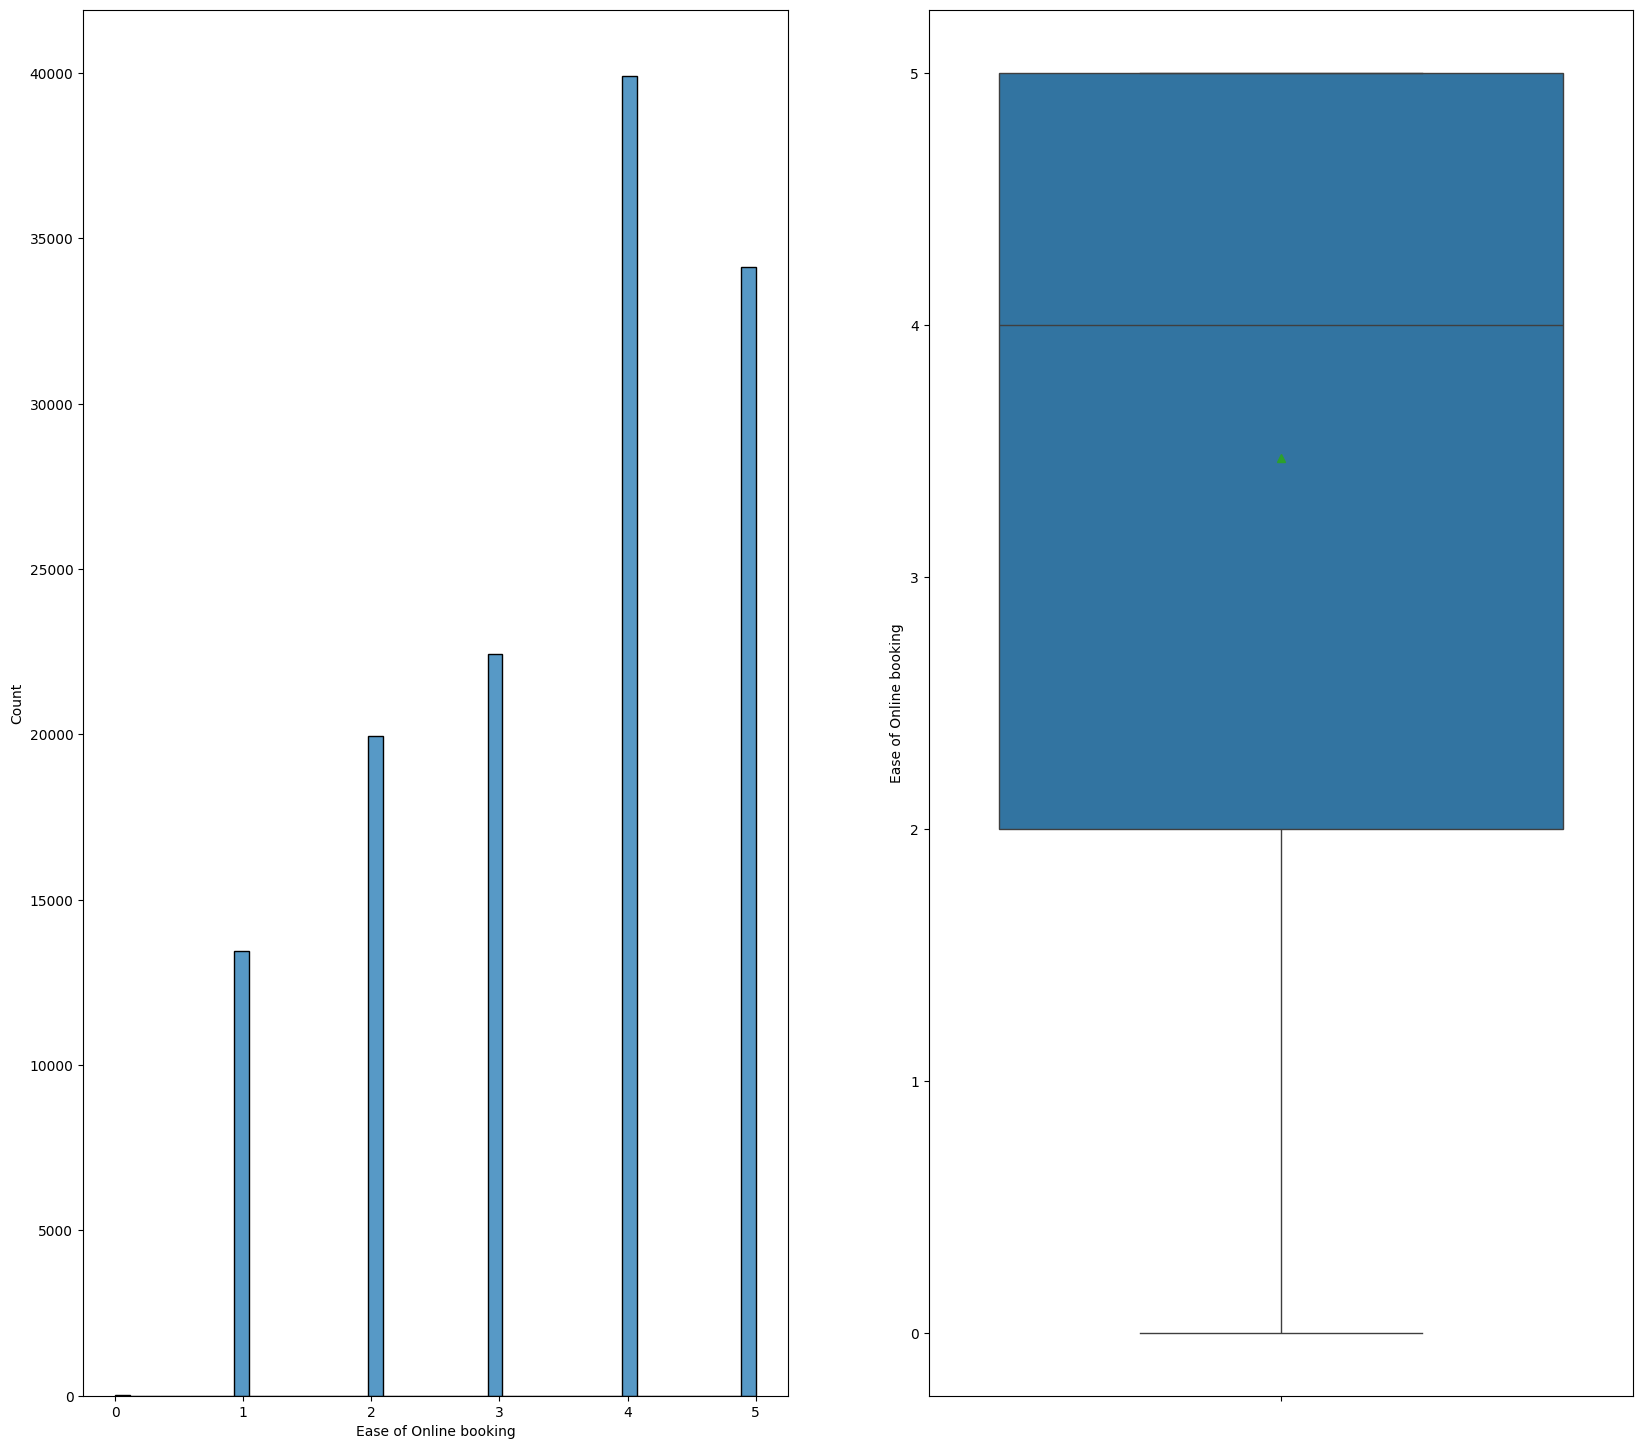

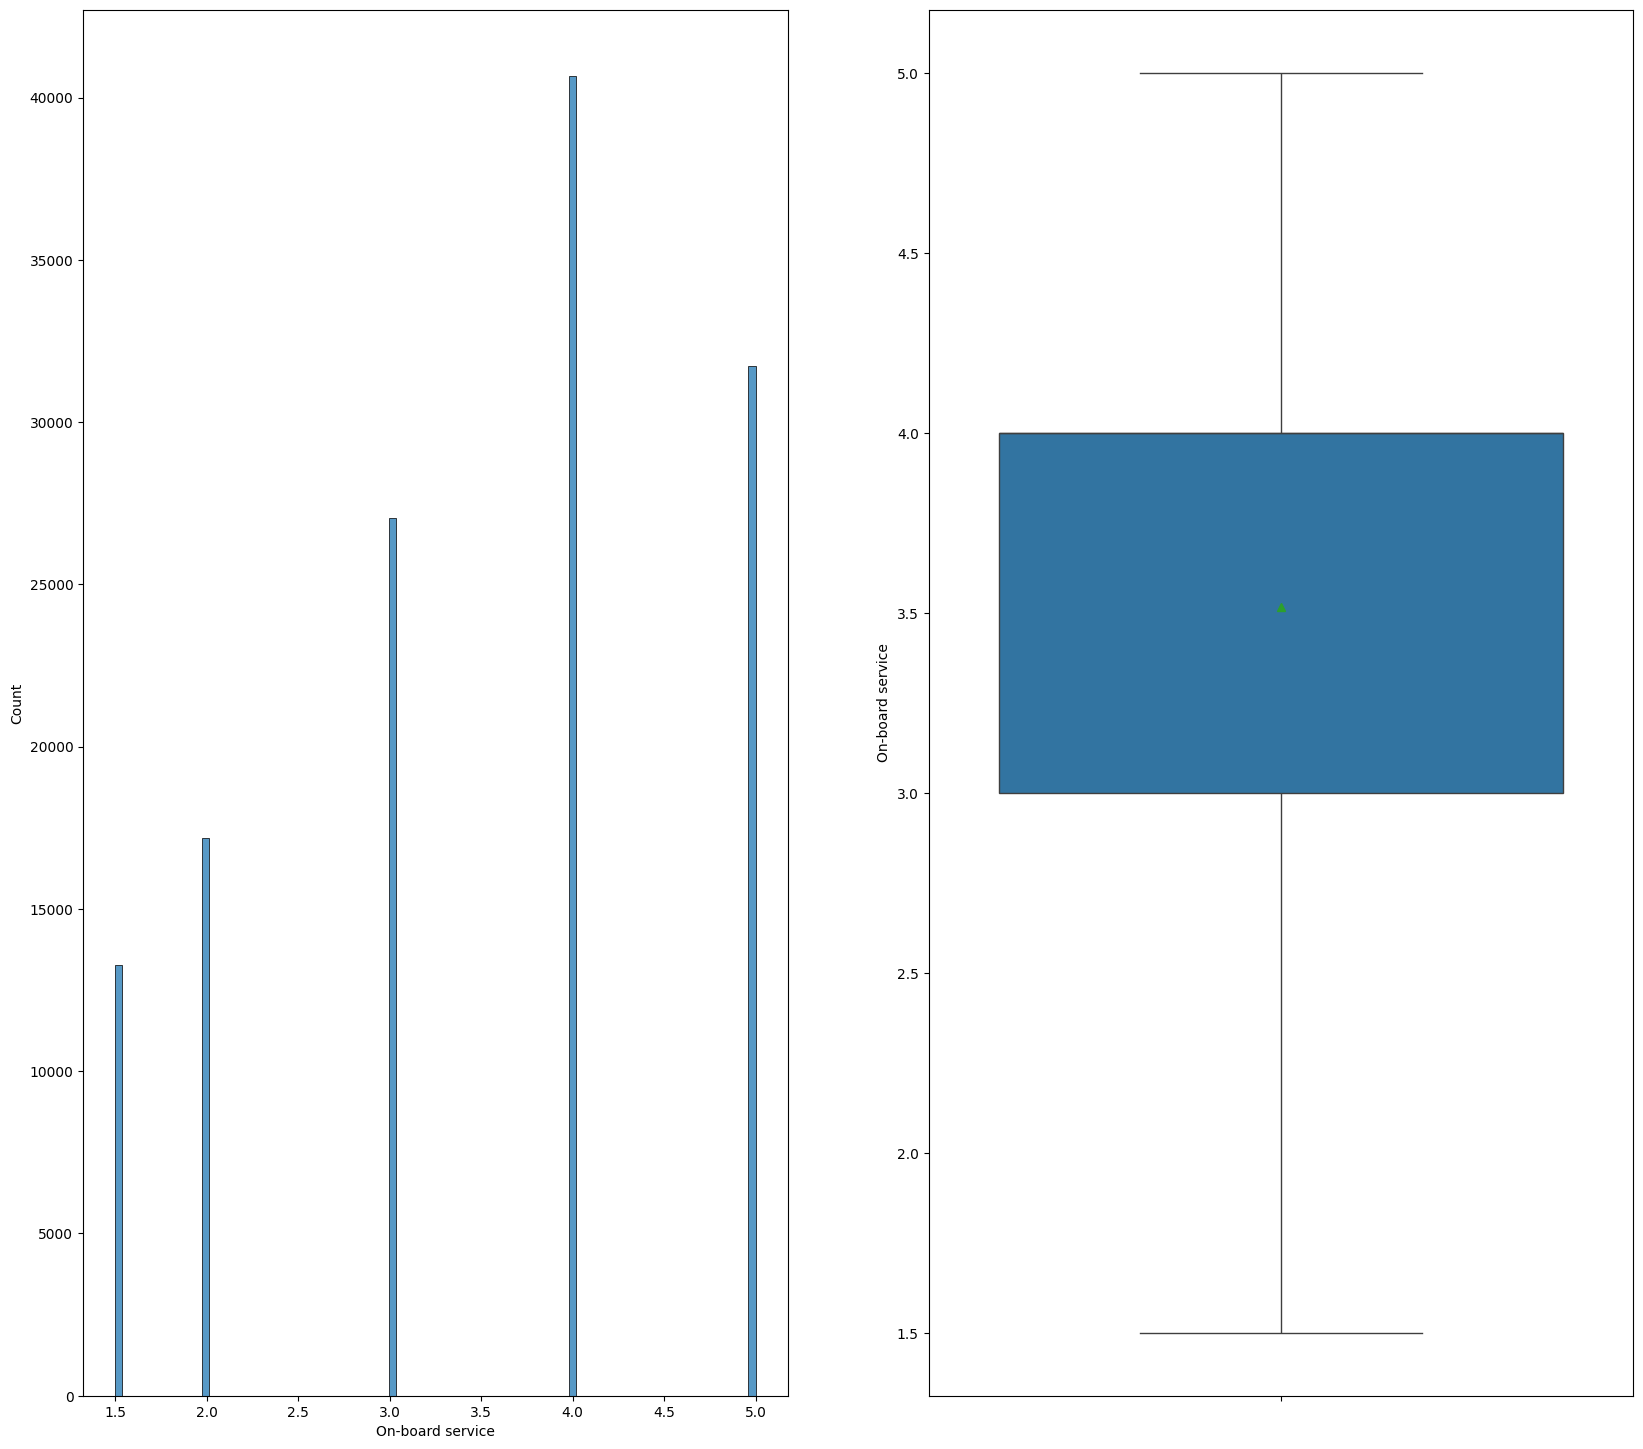

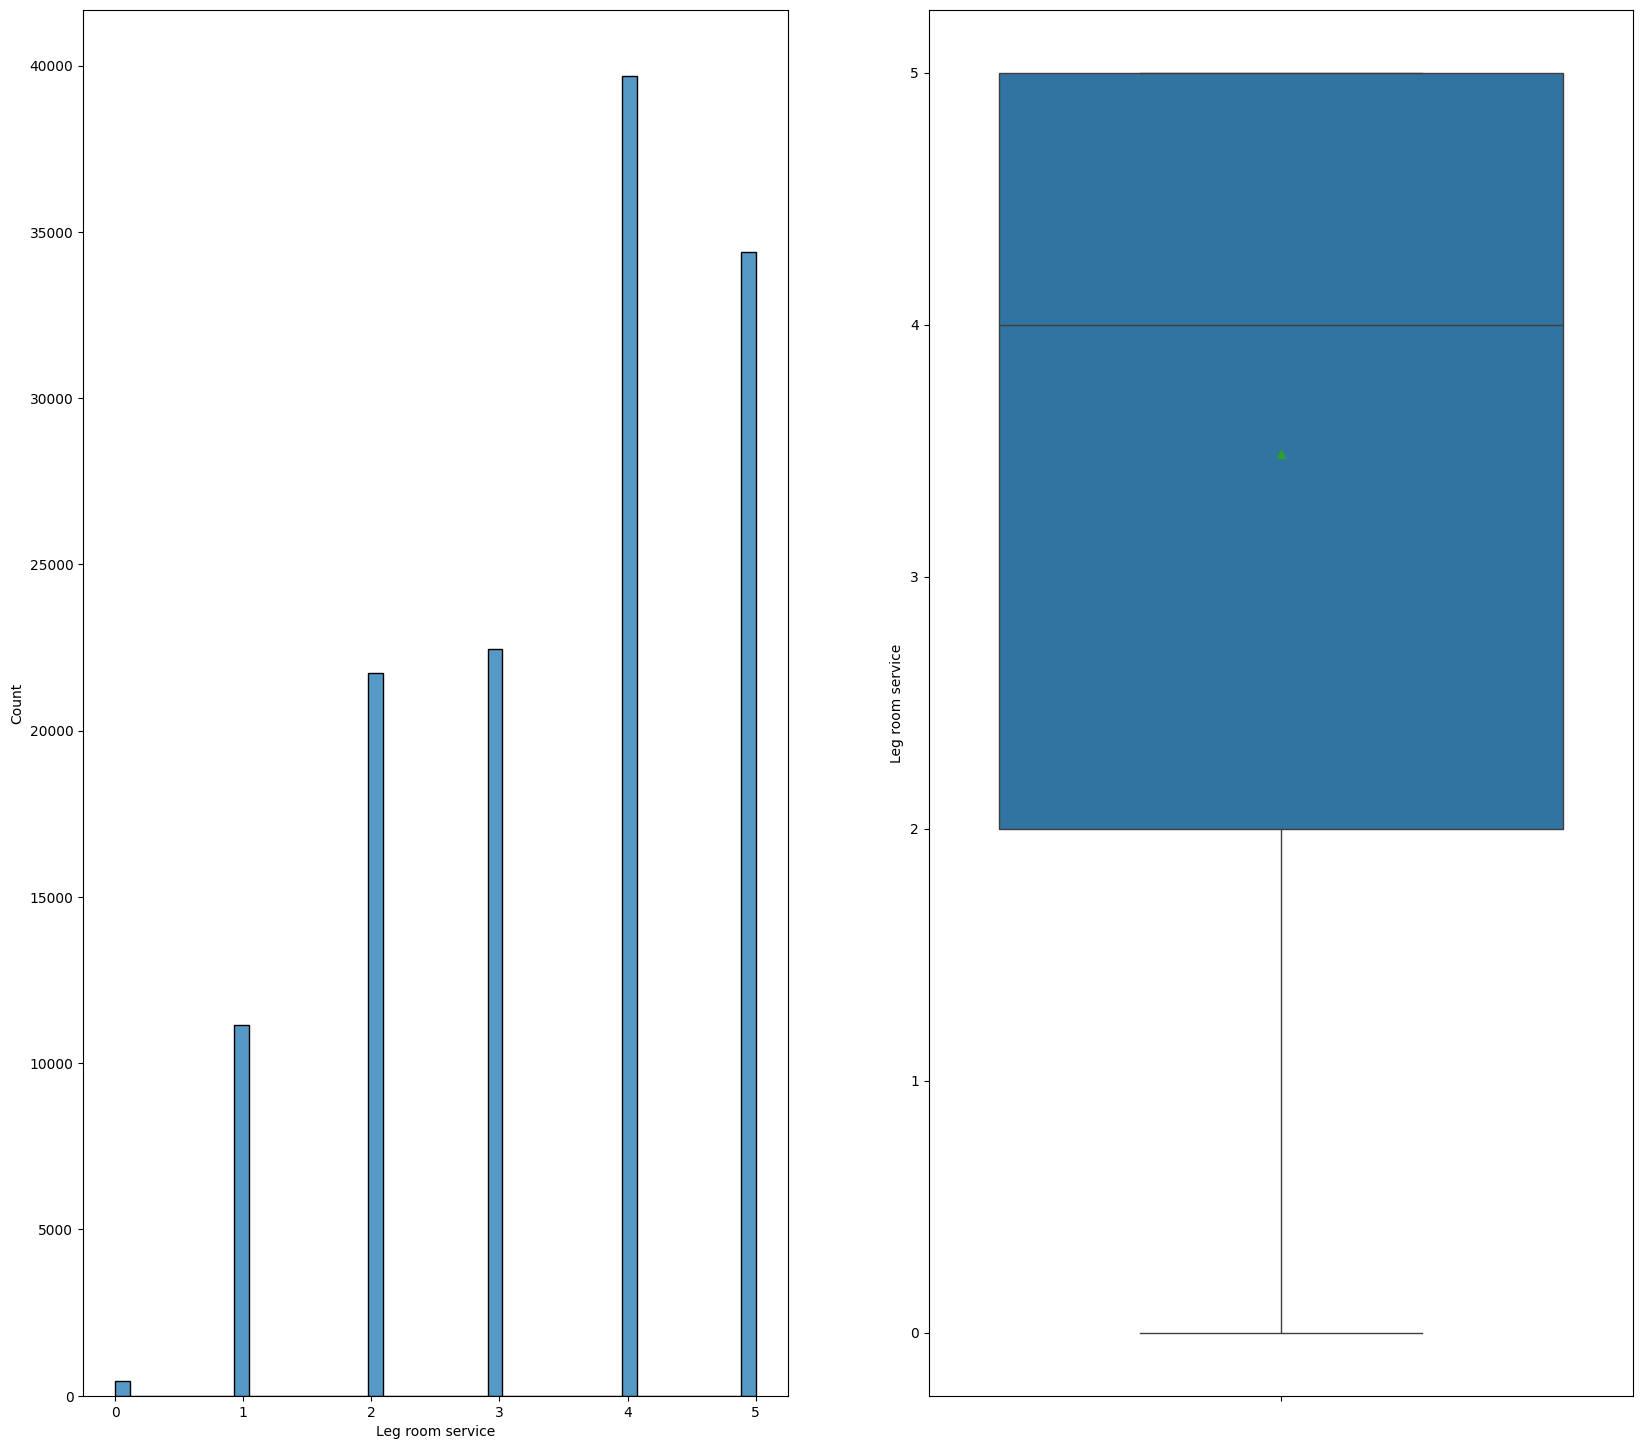

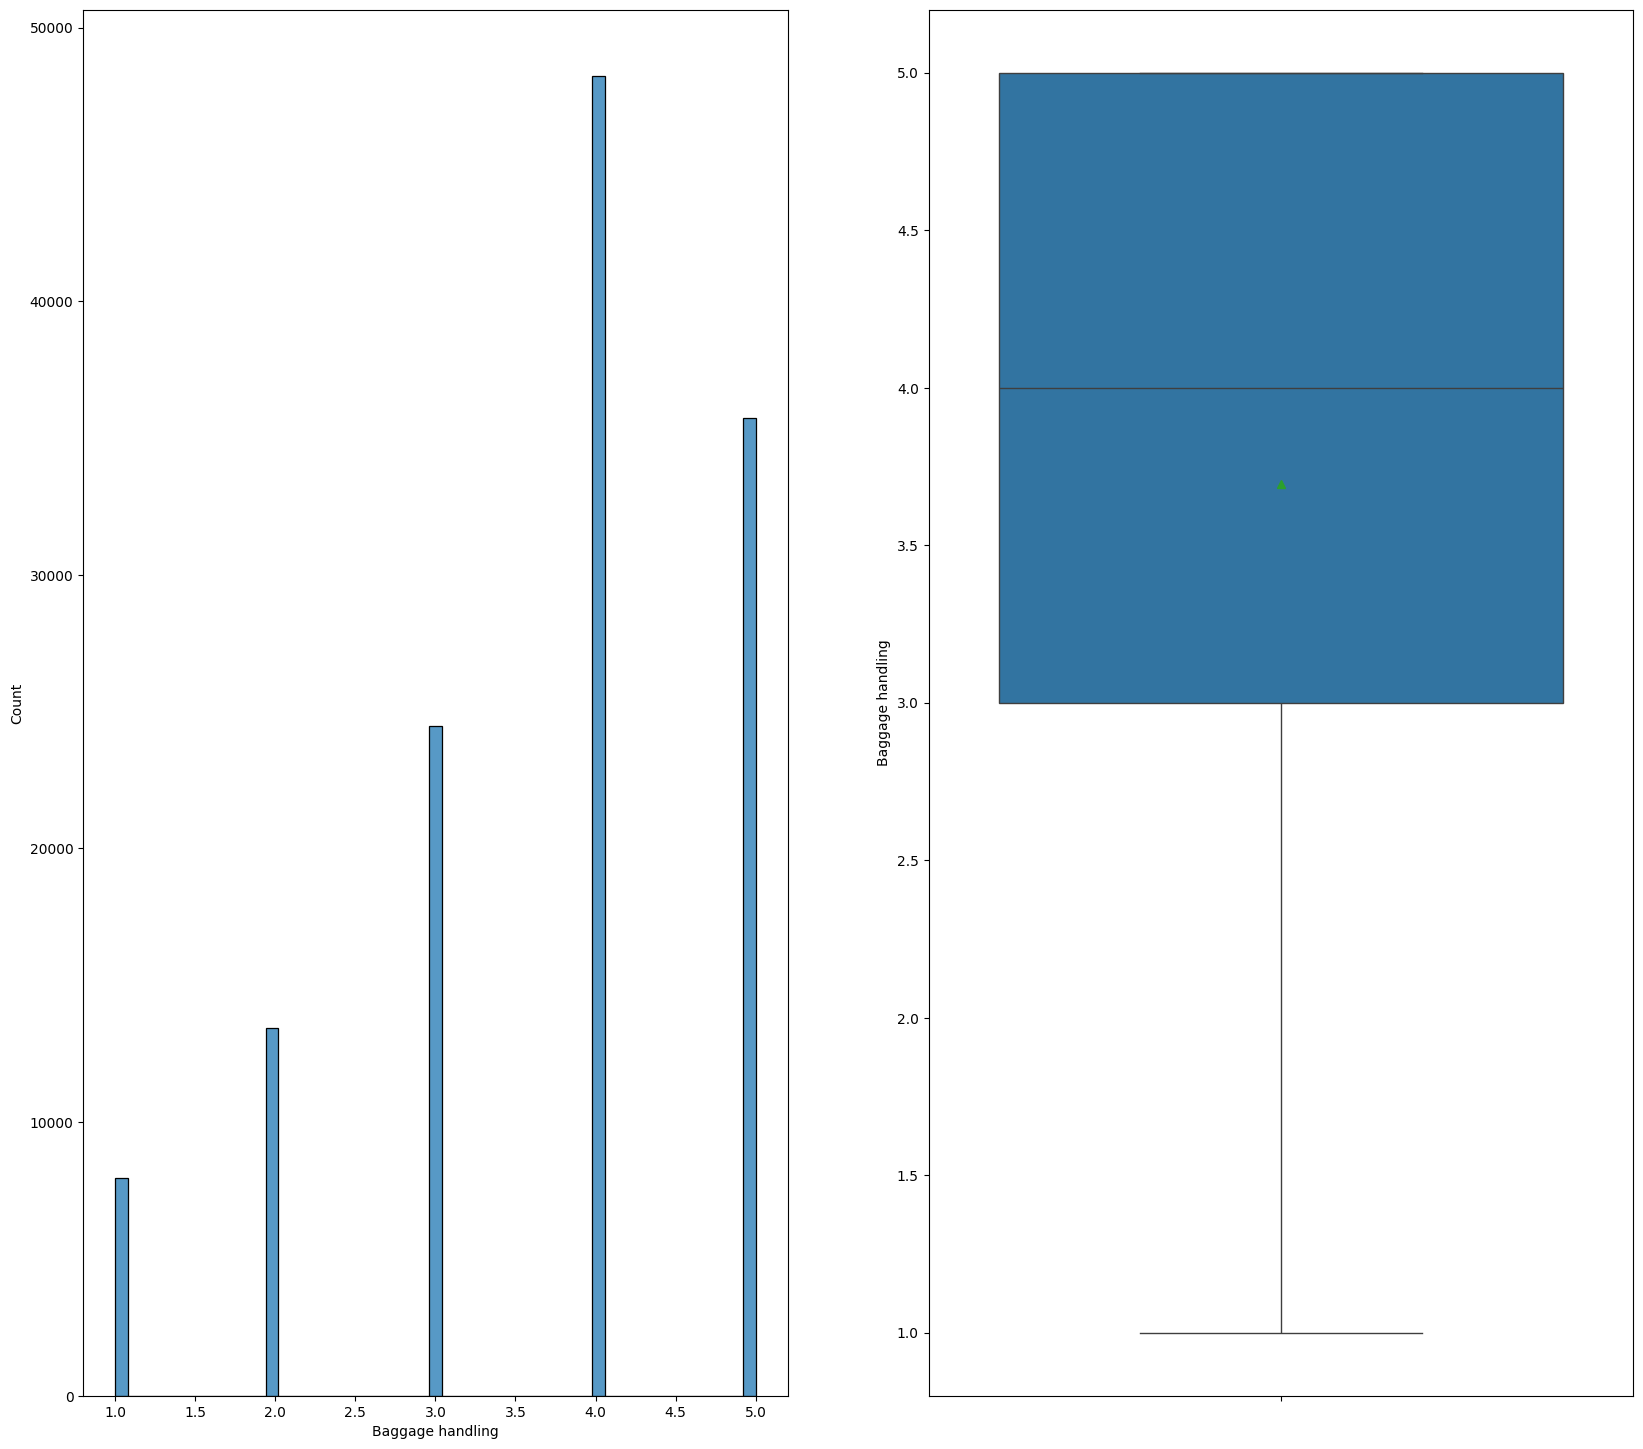

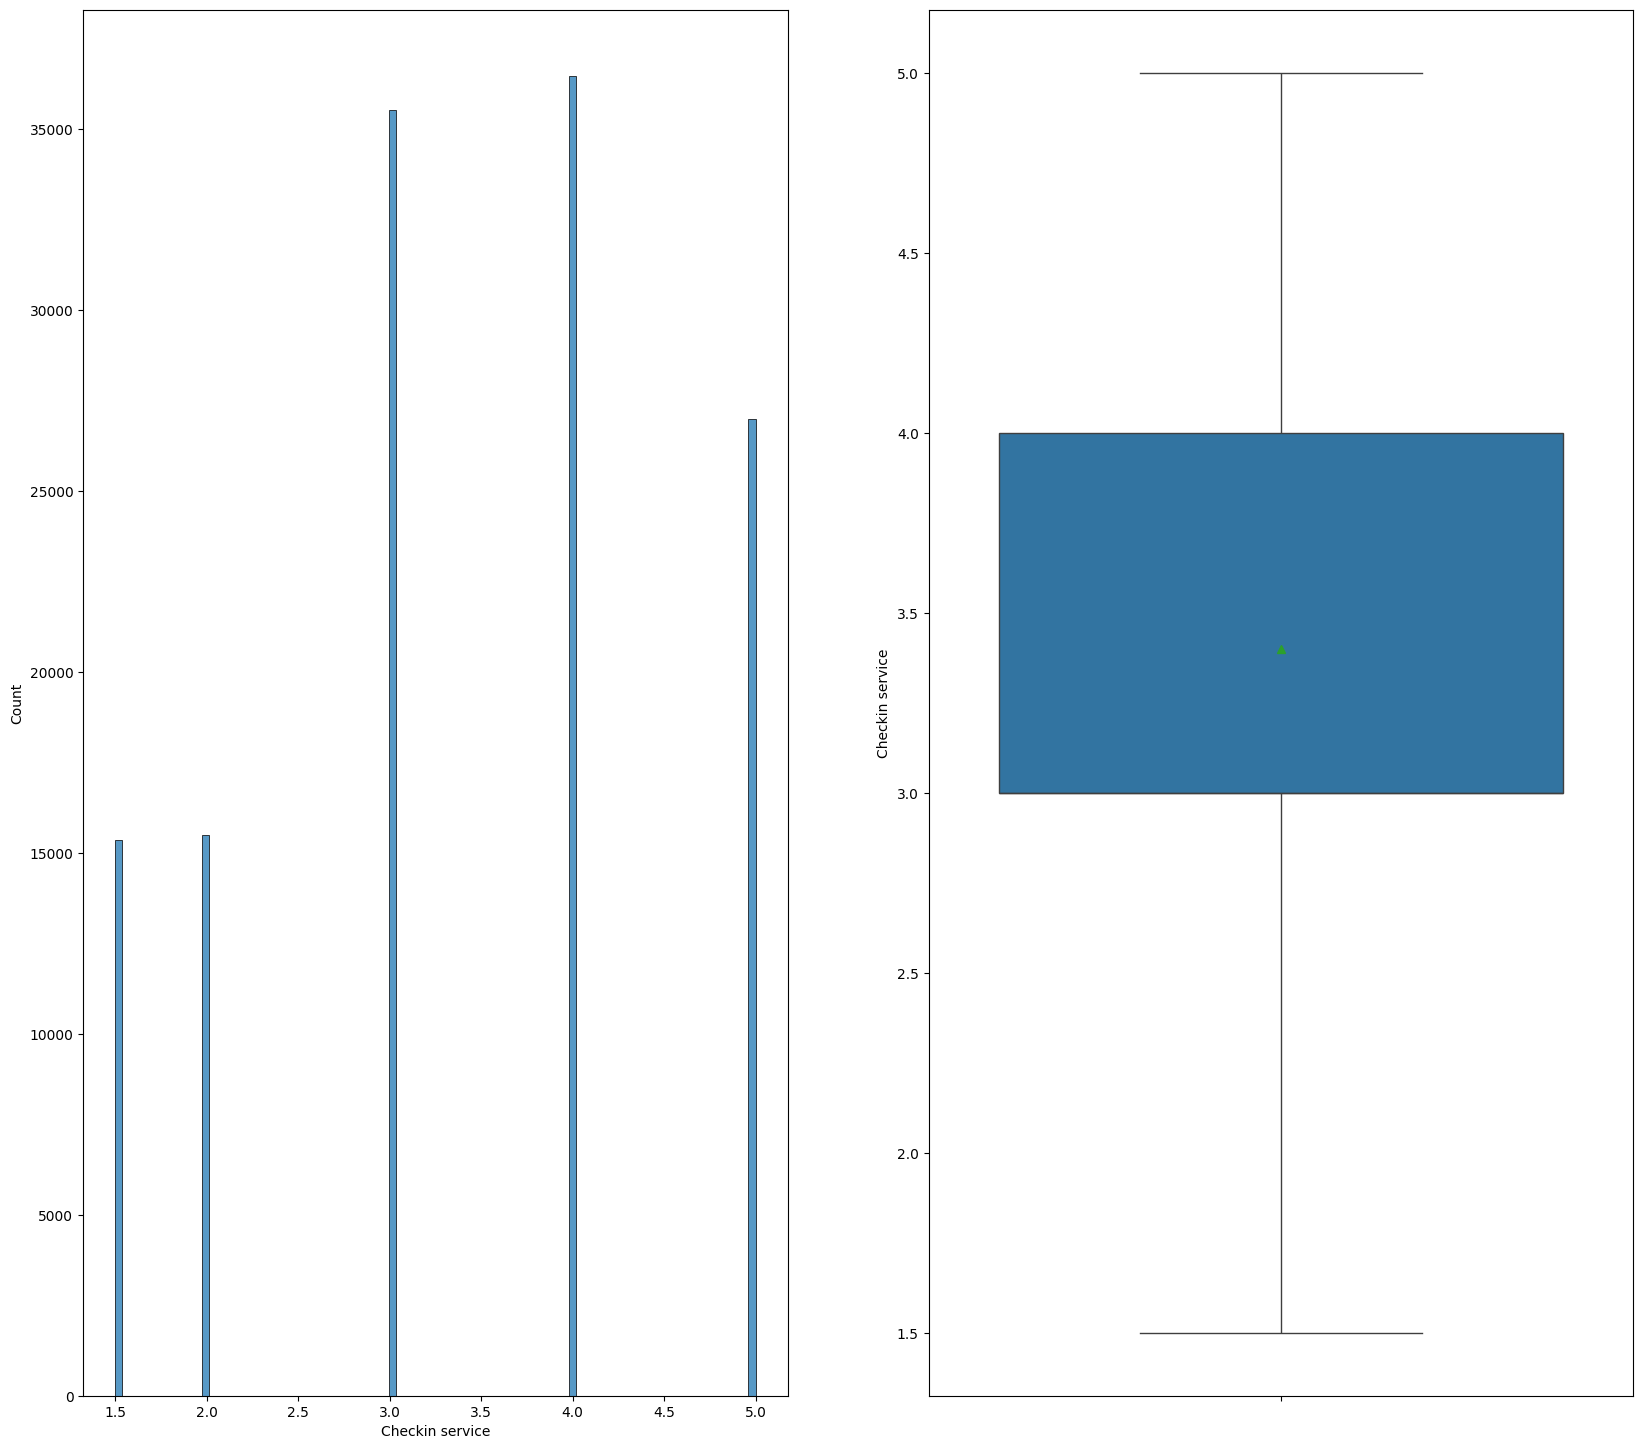

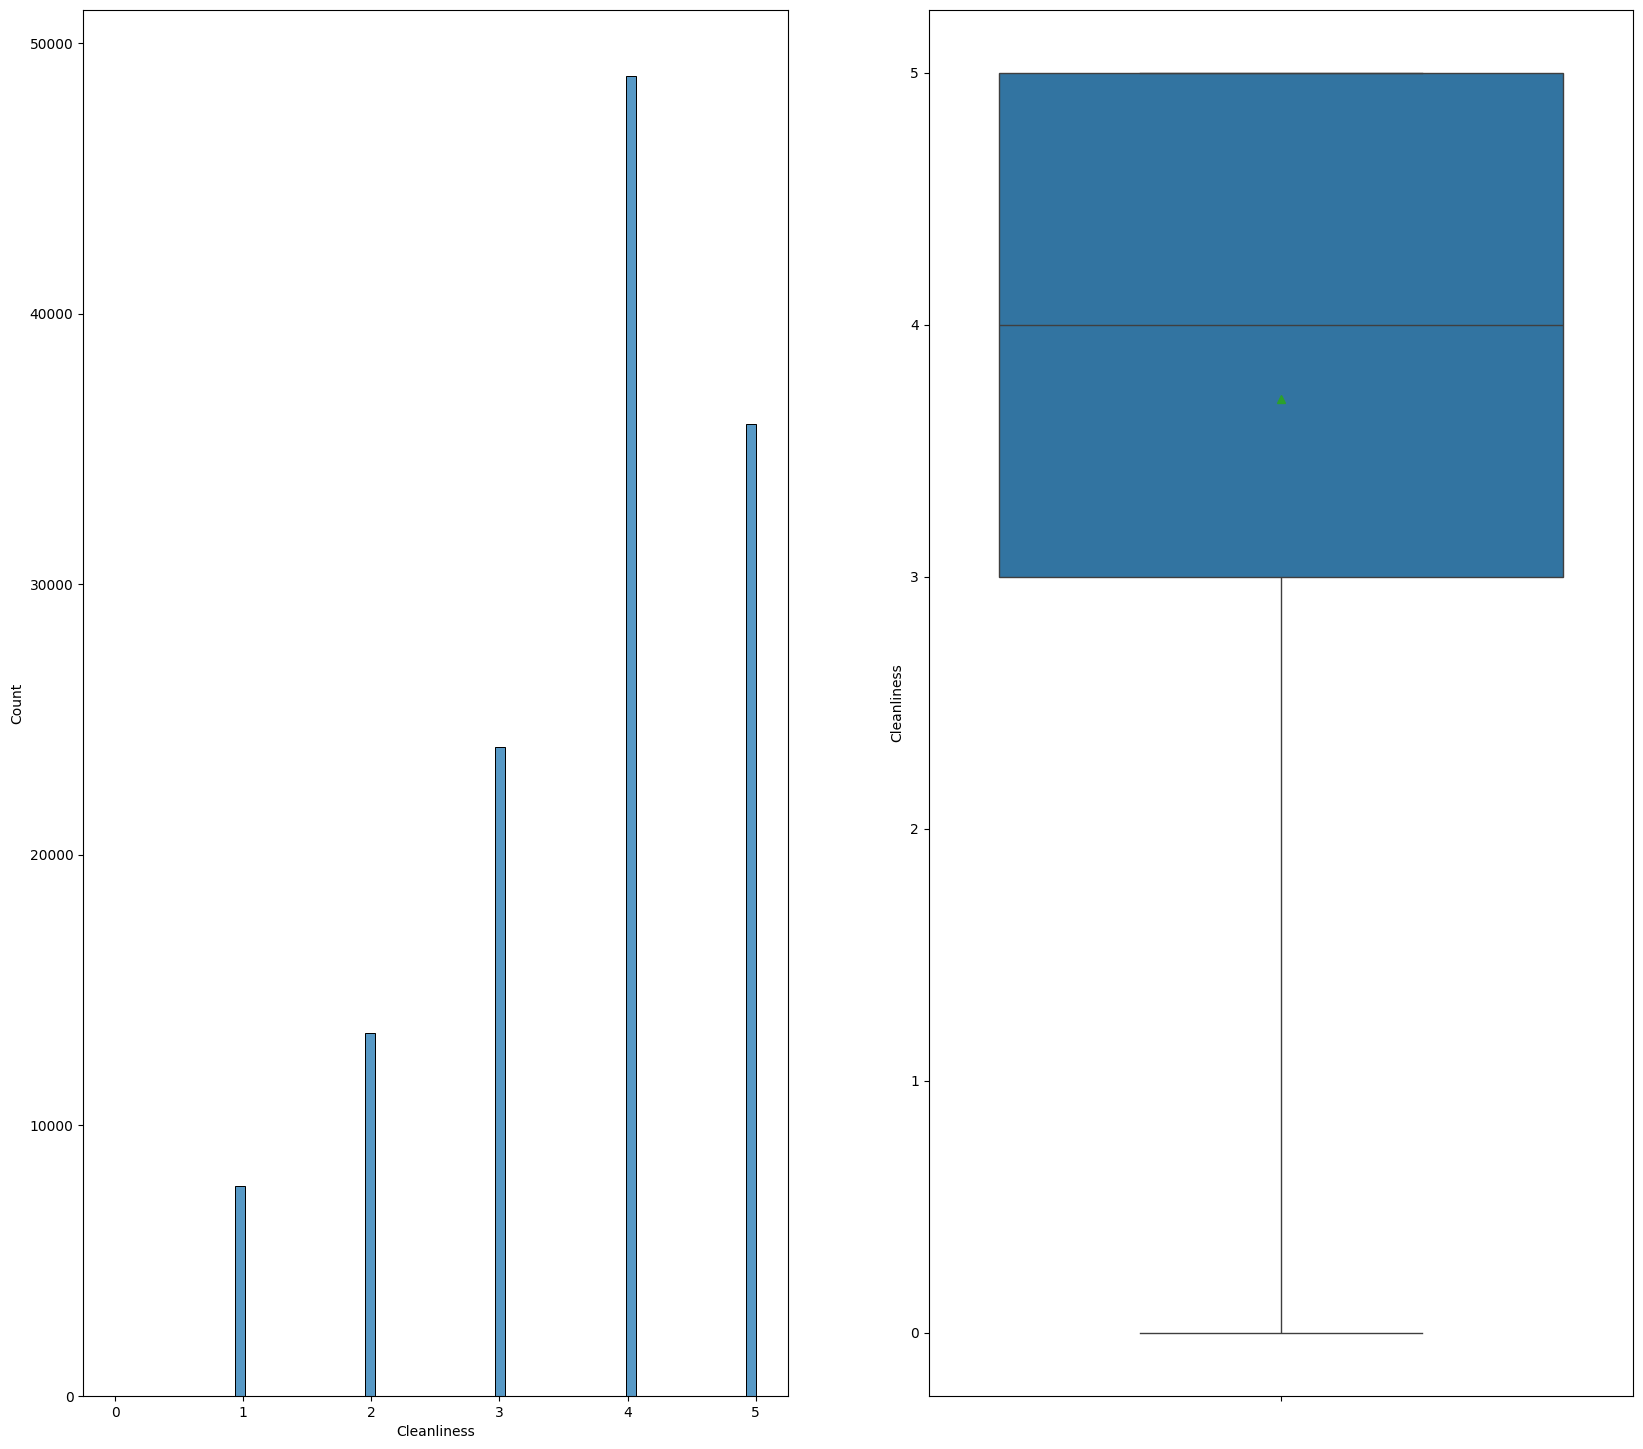

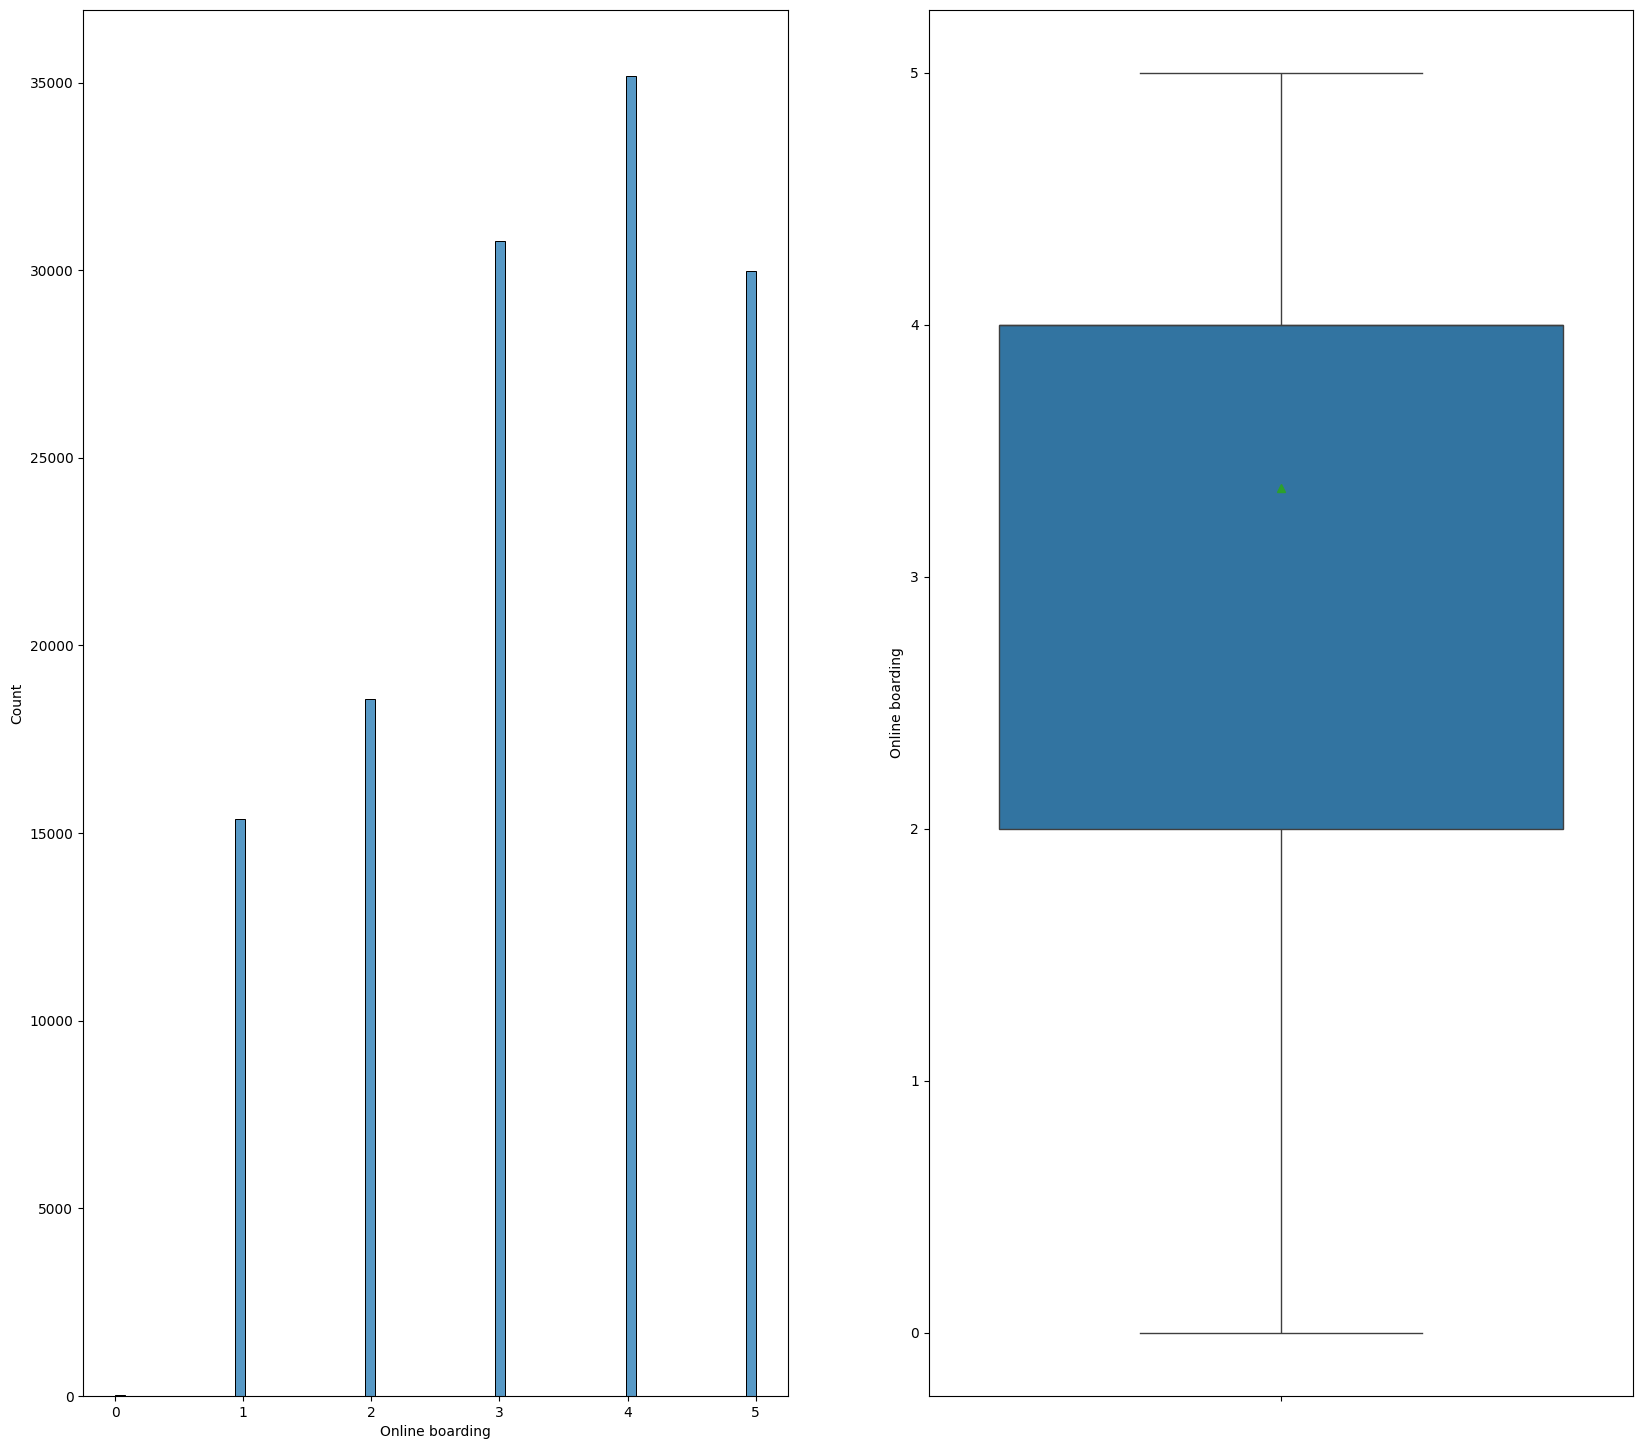

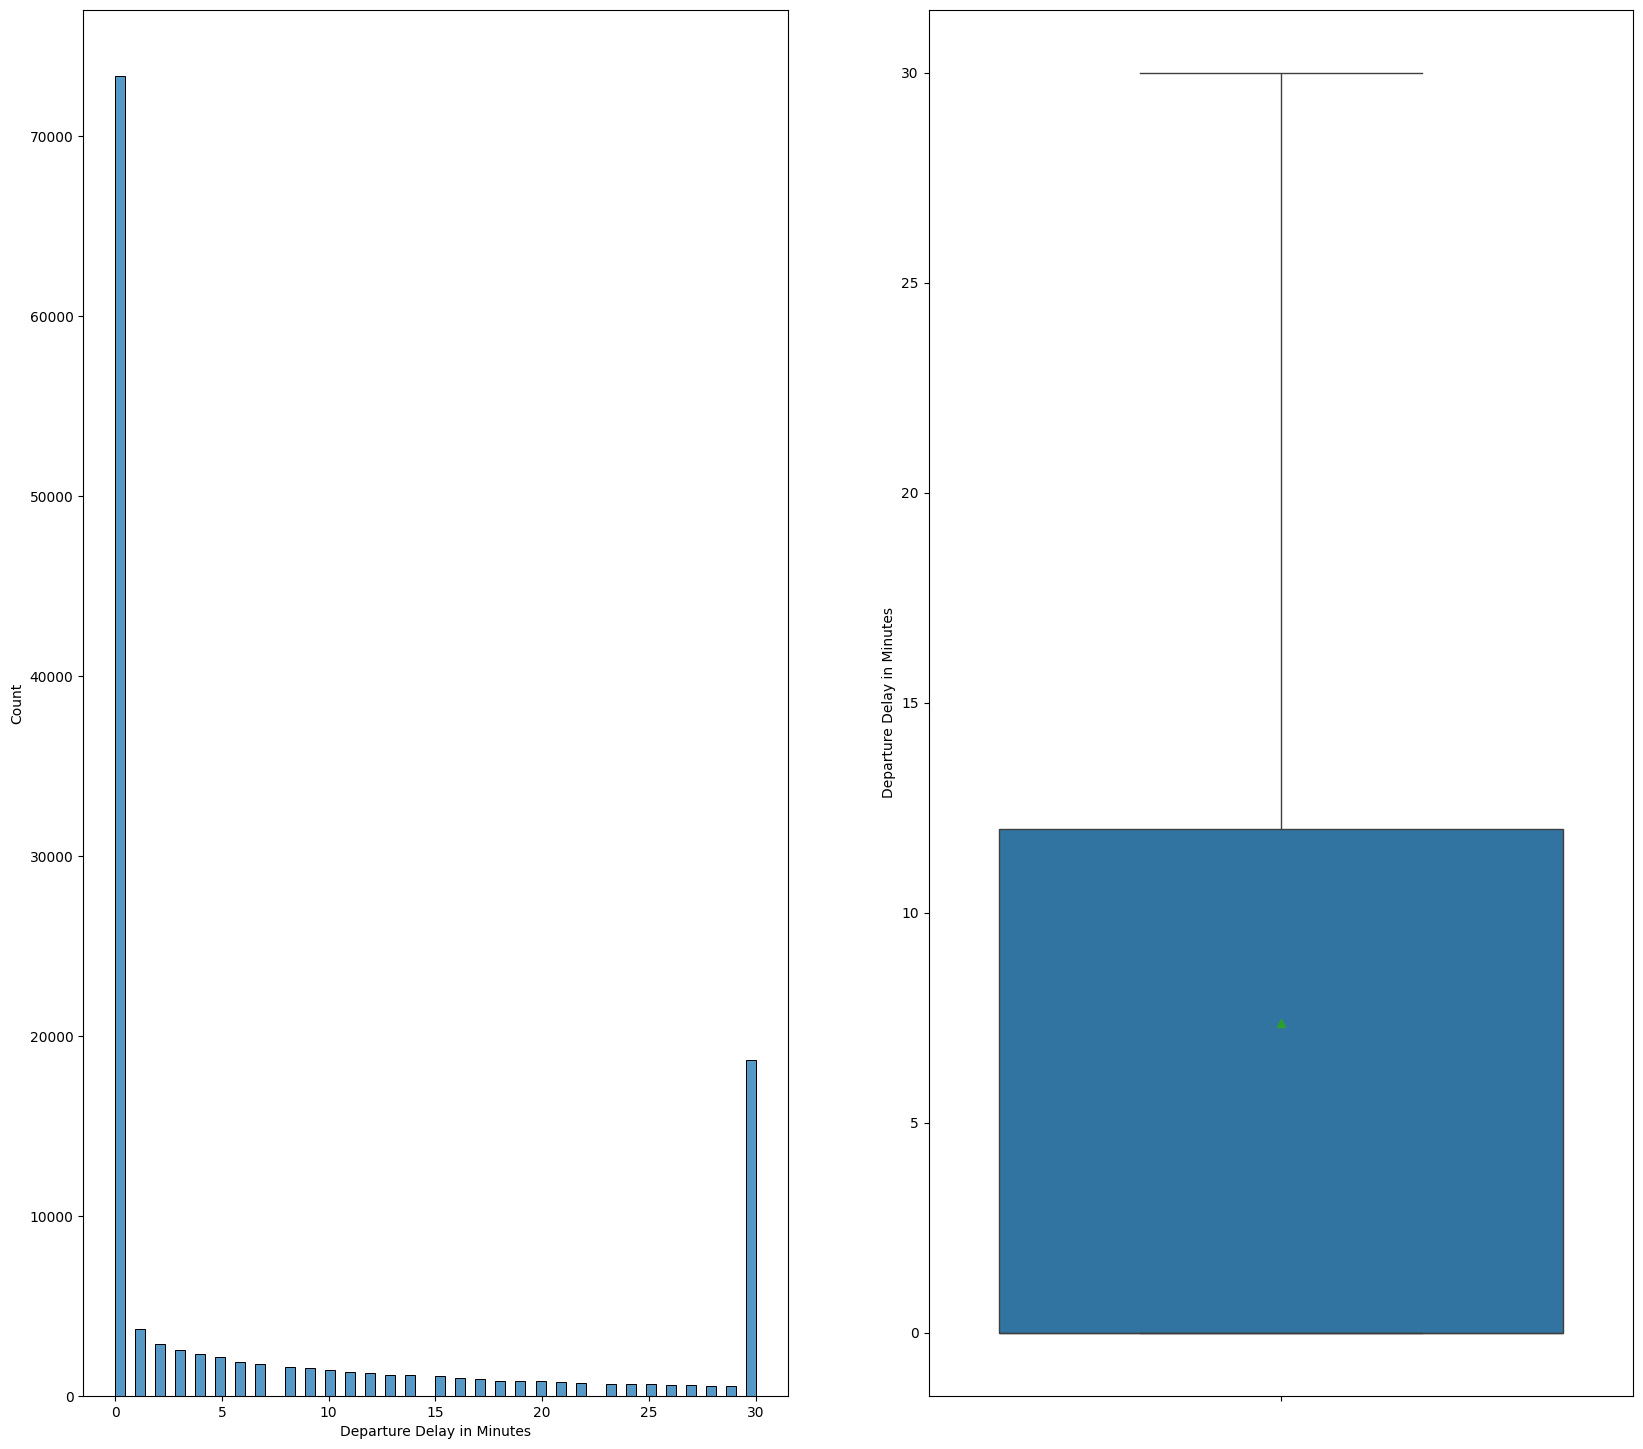

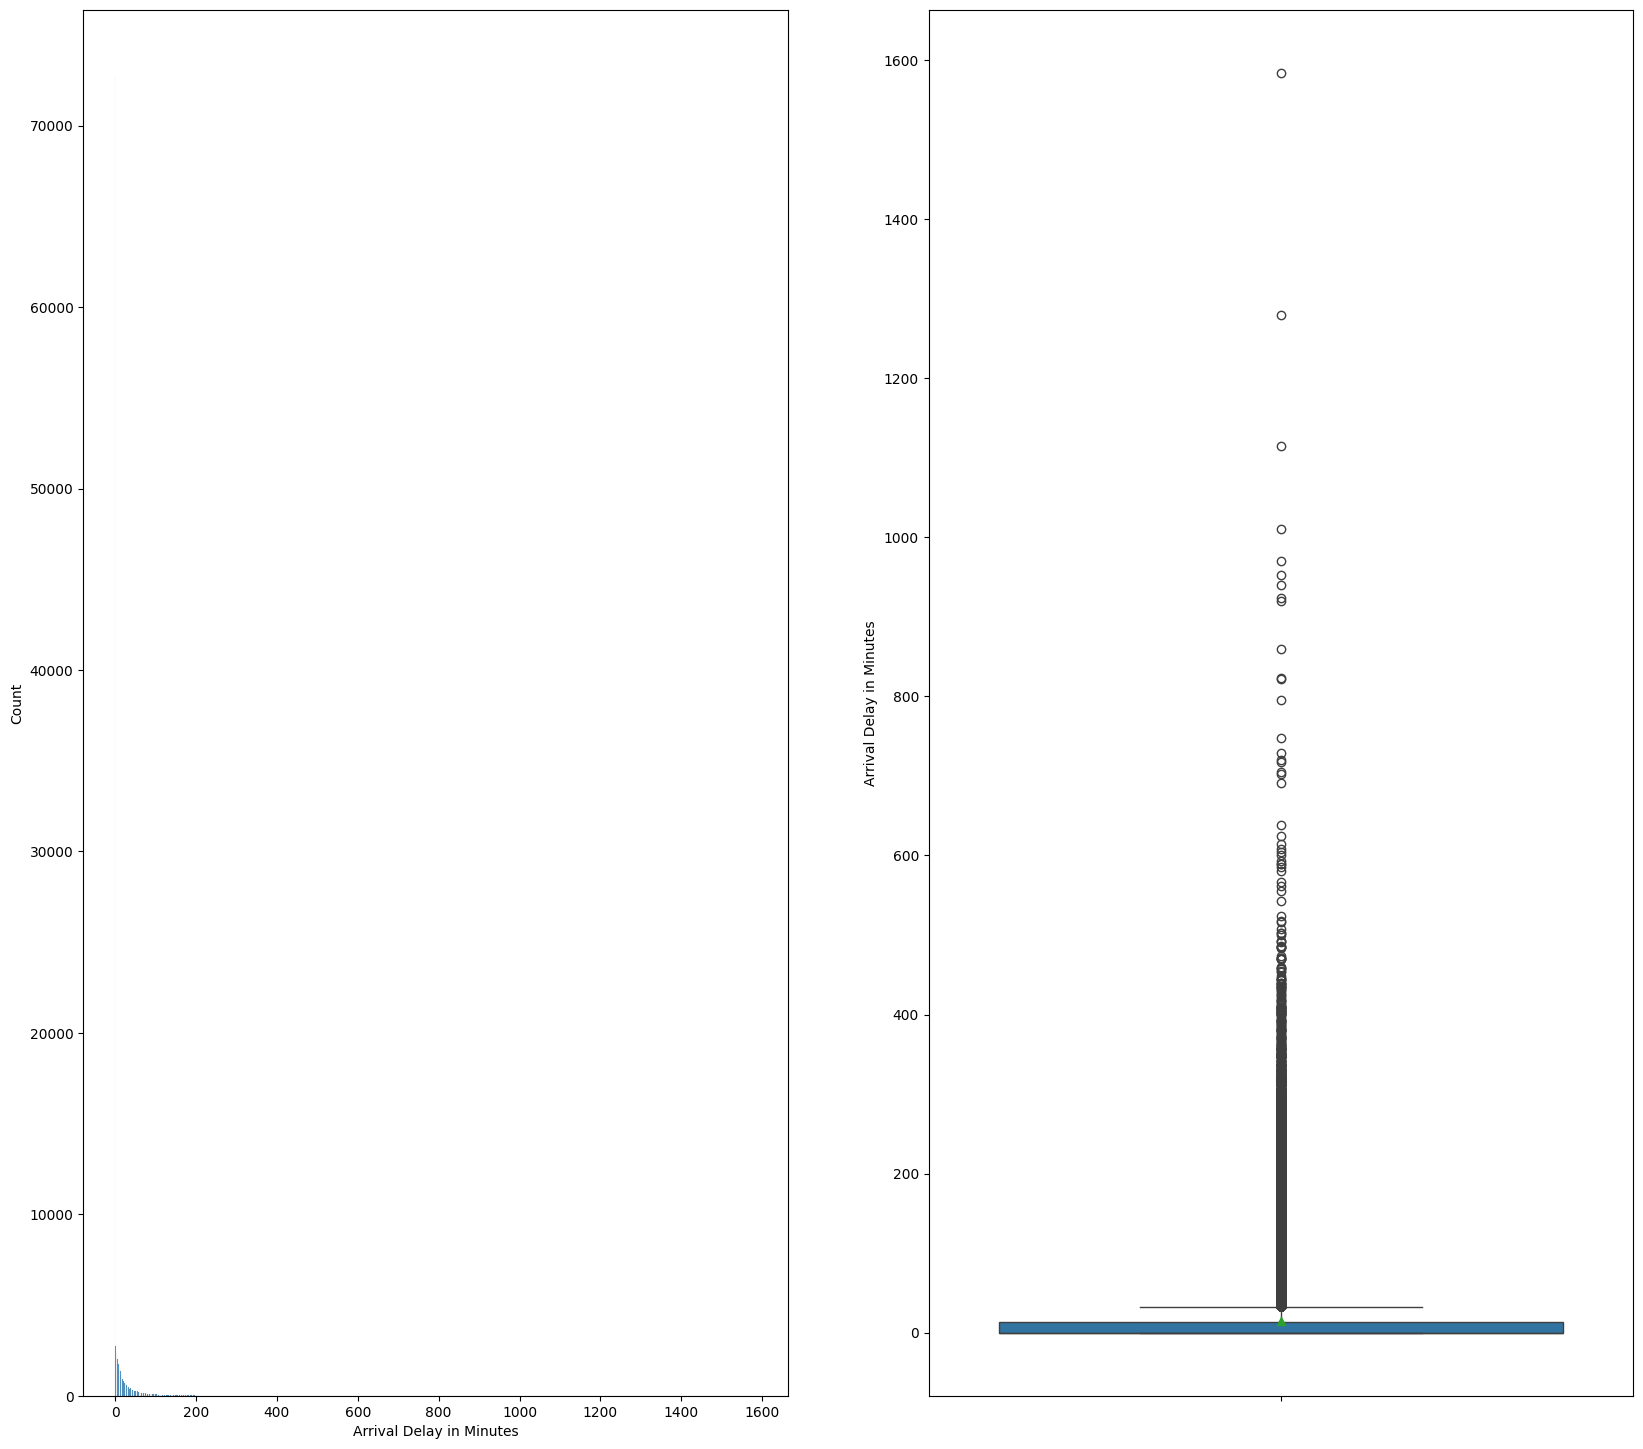

In [14]:
for col in df.select_dtypes('number').columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
    sns.histplot(df[col], ax = axes[0])
    sns.boxplot(df[col], ax = axes[1], showmeans=True)
plt.show() 

In [58]:
class DataPreprocessor:
    """
    Prétraitement des Données

    • Nettoyage : Imputer les valeurs manquantes.
    • Encodage des variables catégorielles : Appliquer l’encodage par variables factices (dummy variables)
      pour les données non numériques.
    • Standardisation : Standardiser les données numériques pour améliorer les performances des algorithmes.
    • Livrable : Code et documentation du pipeline de prétraitement des données.

    Attributes:
    -----------
    df : pd.DataFrame
        Le DataFrame contenant les données à traiter.
    target_column : str
        La colonne cible pour le modèle.
    exclude_columns : list
        Les colonnes à exclure du prétraitement (par défaut, aucune colonne n'est exclue).
    test_size : float
        La proportion de l'ensemble de test (par défaut, 0.2).
    random_state : int
        Graine aléatoire pour la reproductibilité du découpage en train/test (par défaut, 0).
    """
    
    def __init__(self, df, target_column, exclude_columns=None, test_size=0.2, random_state=0):
        
        self.df = df
        self.target_column = target_column
        self.exclude_columns = exclude_columns if exclude_columns is not None else []
        self.test_size = test_size
        self.random_state = random_state
        


    def split_data(self):
        """
        Divise les données en ensembles d'entraînement et de test.

        Returns:
        --------
        X_train, X_test, y_train, y_test : tuple
            Données divisées en ensembles d'entraînement et de test.
        """
        y = self.df[self.target_column]
        X = self.df.drop([self.target_column] + self.exclude_columns, axis='columns')
        
        X_train, X_test, y_train, y_test = train_test_split(
                                 X, 
                                 y, 
                                 test_size=self.test_size, 
                                 random_state=self.random_state
                            )
        return X_train, X_test, y_train, y_test
        

    def create_pipeline(self, X_train):
        """
        Crée un pipeline de prétraitement pour les données.

        Étapes du pipeline :
        - Imputation des valeurs manquantes.
        - Standardisation des colonnes numériques.
        - Encodage des variables catégorielles avec des variables factices.

        Parameters:
        -----------
        X_train : pd.DataFrame
            Données d'entraînement pour déterminer les types de colonnes.

        Returns:
        --------
        full_pipeline : ColumnTransformer
            Pipeline de transformations pour le prétraitement complet des données.
        """
        num_cols = X_train.select_dtypes(include=['number']).columns
        cat_cols = X_train.select_dtypes(include='object').columns
        num_pipeline = make_pipeline(
                    SimpleImputer(strategy='median'),
                    StandardScaler(),
                )
        cat_pipeline = make_pipeline(
                    SimpleImputer(strategy='most_frequent'),
                    OneHotEncoder(handle_unknown='ignore', drop='first')
                )
        full_pipeline = make_column_transformer(
                (num_pipeline, num_cols),
                (cat_pipeline, cat_cols)
            )
        return full_pipeline

In [59]:
preprocessing = DataPreprocessor(df, 'satisfaction',random_state=10)
X_train, X_test, y_train, y_test = preprocessing.split_data()
pipeline = preprocessing.create_pipeline(X_train)

In [60]:
X_train_transform = pipeline.fit_transform(X_train)
X_test_transform = pipeline.transform(X_test)

### 3. Réduction de Dimensionnalité avec l’ACP

### - Appliquer l’ACP pour réduire les dimensions du dataset à 2 ou 3 dimensions

In [61]:
pca = PCA(n_components = 3)
X_train_reduce = pca.fit_transform(X_train_transform)
X_test_reduce = pca.transform(X_test_transform)

### - Visualisation 2D les données projetées pour explorer les groupes et les clusters éventuels

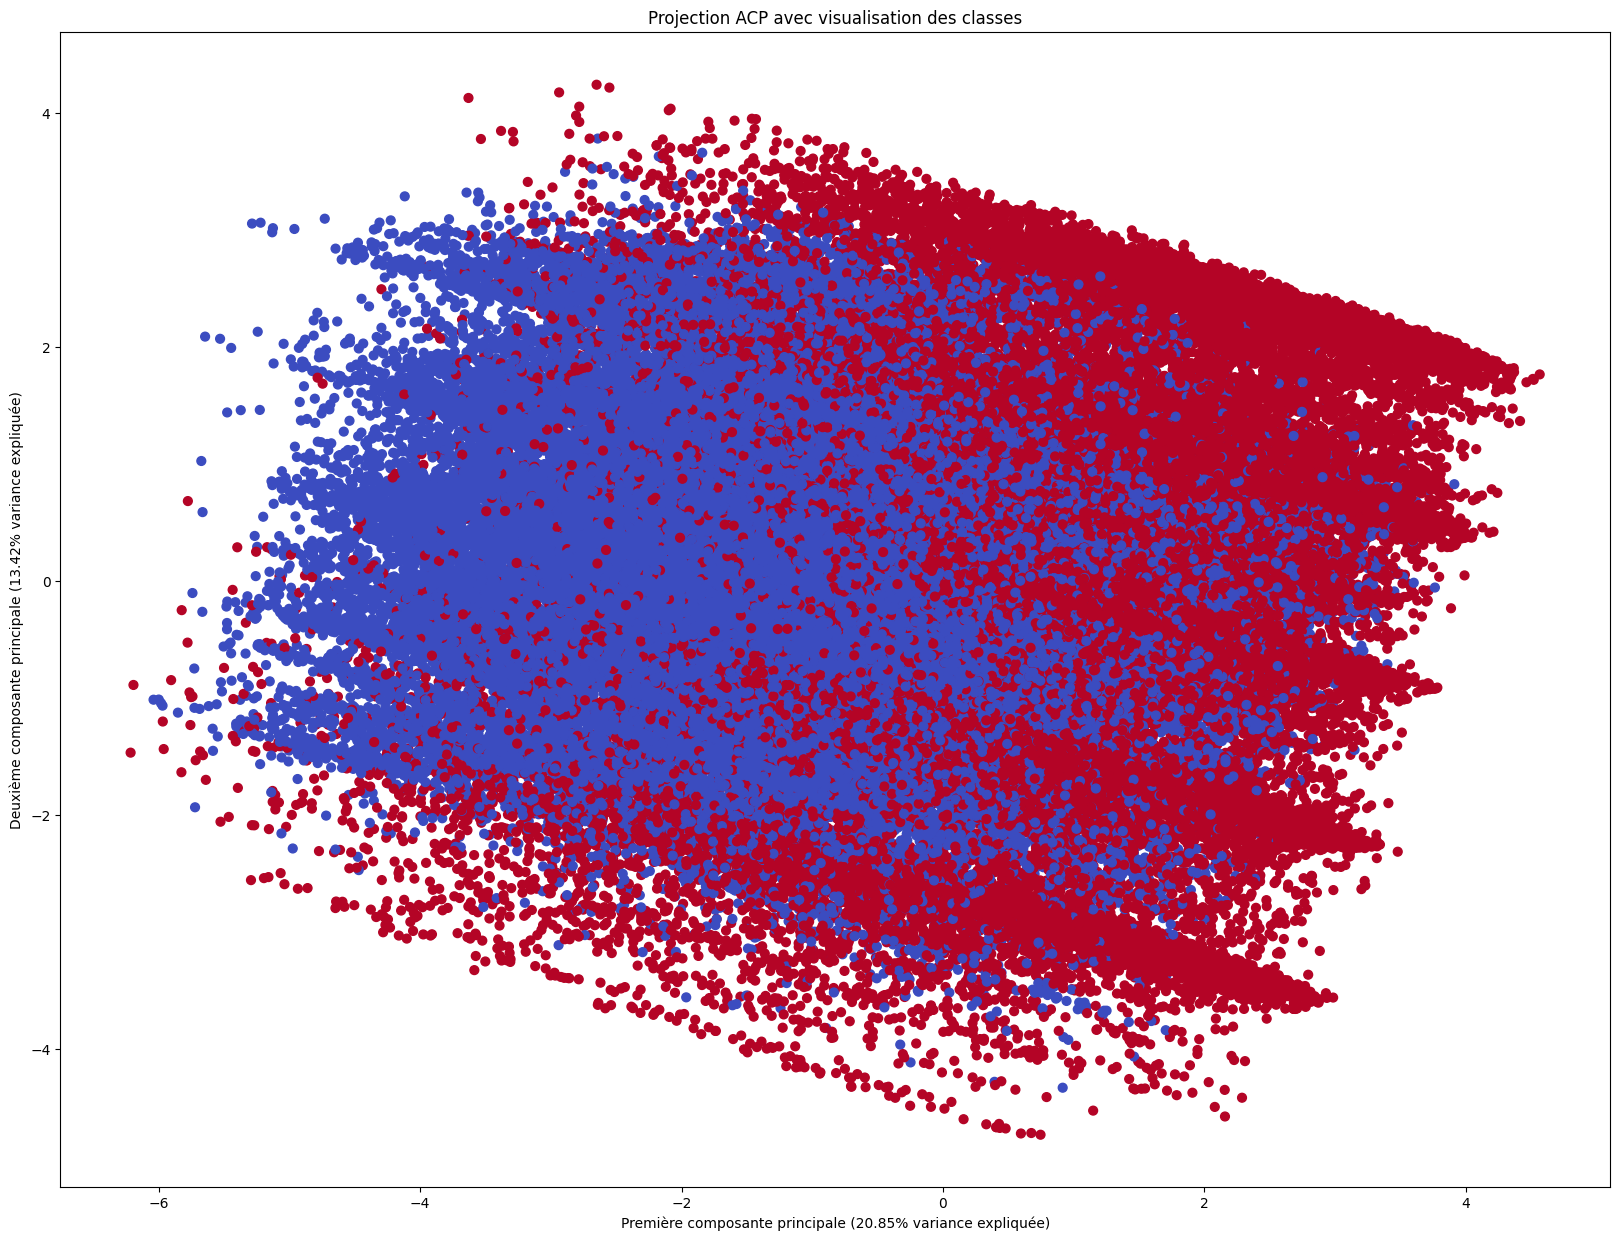

In [62]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)


plt.figure(figsize=(20, 15))
scatter = plt.scatter(X_train_reduce[:, 0], X_train_reduce[:, 1], 
                     c=y_train_encoded,
                      cmap='coolwarm',
                     s=40)

plt.xlabel(f'Première composante principale ({pca.explained_variance_ratio_[0]:.2%} variance expliquée)')
plt.ylabel(f'Deuxième composante principale ({pca.explained_variance_ratio_[1]:.2%} variance expliquée)')
plt.title('Projection ACP avec visualisation des classes')
plt.show()

En effectuant une visualisation 2D sur les deux premieres composantes de l'ACP, nous remarquons deja deux groupes de clients que nous supposerons satisfait et non satisfait.

### Visualisation 3D

In [63]:
df_pca = pd.DataFrame(X_train_reduce, columns=['PC1', 'PC2', 'PC3'])
df_pca['satisfaction'] = y_train 

def plot_3d_individuals(df_pca, pca):
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(111, projection='3d')
    
    le = LabelEncoder()
    satisfaction_encoded = le.fit_transform(df_pca['satisfaction'])
    

    scatter = ax.scatter(df_pca['PC1'], 
                         df_pca['PC2'], 
                         df_pca['PC3'],
                         c=satisfaction_encoded,
                         cmap='coolwarm',
                         s=80, 
                         alpha=0.6)

    
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)")
    
    ax.set_title('Visualisation 3D des composantes principales')

    plt.show()
    

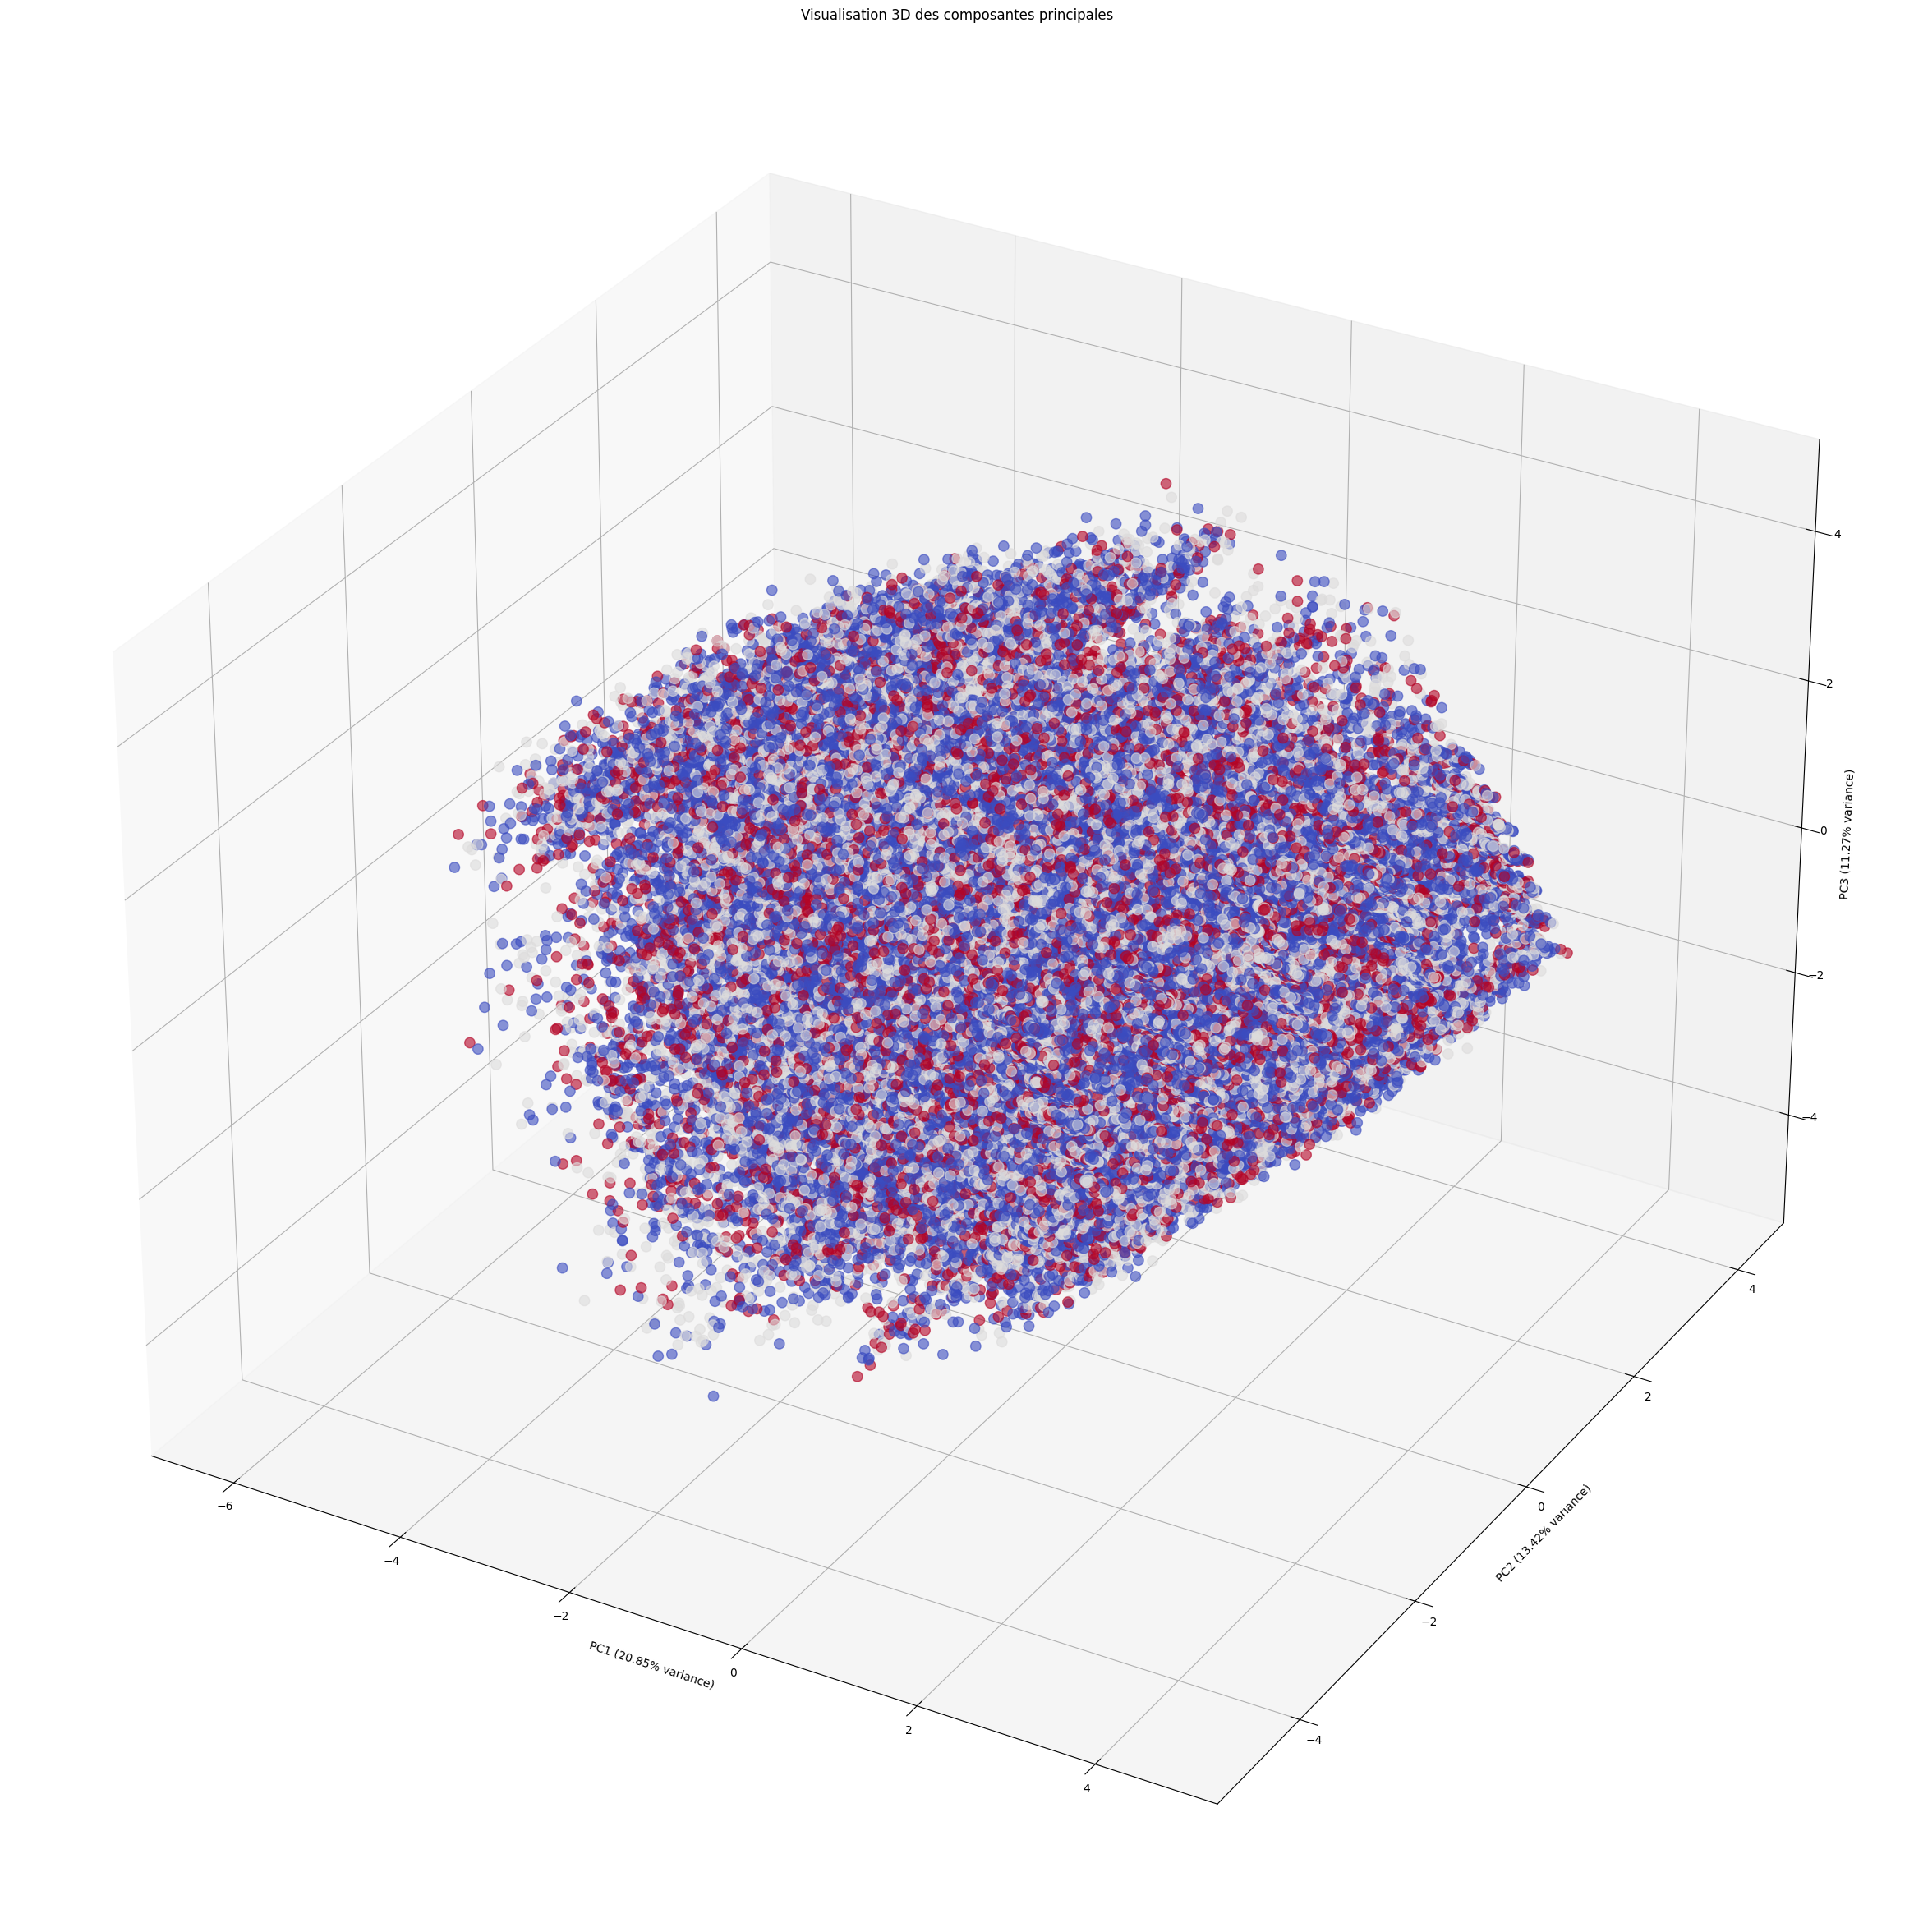

In [64]:
plot_3d_individuals(df_pca, pca)

### 4. Modélisation et Prédiction

### - Appliquer KNN pour classer la satisfaction (satisfait/non-satisfait)

In [65]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_reduce, y_train)
y_pred_knn = model_knn.predict(X_test_reduce)
rapport_KNN = classification_report(y_test, y_pred_knn)
print(rapport_KNN)

              precision    recall  f1-score   support

dissatisfied       0.82      0.82      0.82     11864
   satisfied       0.85      0.84      0.85     14112

    accuracy                           0.83     25976
   macro avg       0.83      0.83      0.83     25976
weighted avg       0.83      0.83      0.83     25976



### - Appliquer Naïve Baye

In [66]:
model_NB = GaussianNB()
model_NB.fit(X_train_reduce, y_train)
y_pred_NB = model_NB.predict(X_test_reduce)
rapport_NB = classification_report(y_test, y_pred_NB)
print(rapport_NB)

              precision    recall  f1-score   support

dissatisfied       0.78      0.70      0.74     11864
   satisfied       0.77      0.84      0.80     14112

    accuracy                           0.77     25976
   macro avg       0.77      0.77      0.77     25976
weighted avg       0.77      0.77      0.77     25976



###  5. Évaluation et Optimisation des Modèles

## Affichons les parametres pour les modeles pour rechercher les hyperparametres pour optimiser les models

In [67]:
print(model_knn.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [68]:
print(model_NB.get_params())

{'priors': None, 'var_smoothing': 1e-09}


### -Utiliser le cross validation pour évaluer les modèles et éviter le surapprentissage.

In [72]:
scores_knn = cross_val_score(model_knn, X_train_reduce, y_train, cv=5, scoring='accuracy')
print(f"Scores de validation croisée: {scores_knn}")
print(f"Précision moyenne: {scores_knn.mean():.2f}")

Scores de validation croisée: [0.82681295 0.82700544 0.83071075 0.83051826 0.82959577]
Précision moyenne: 0.83


In [73]:
scores_nb = cross_val_score(model_NB, X_train_reduce, y_train, cv=5, scoring='accuracy')
print(f"Scores de validation croisée: {scores_nb}")
print(f"Précision moyenne: {scores_nb.mean():.2f}")

Scores de validation croisée: [0.76252346 0.77662288 0.76574756 0.76954911 0.77285852]
Précision moyenne: 0.77


### -Utiliser le GridSearch cv pour optimiser les hyper parametres du KNN.

In [74]:
param_grid = {'n_neighbors': range(1, 20), 'metric': ['minkowski','euclidean', 'manhattan'], 'weights': ['uniform','distance']}

grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_reduce, y_train)

print("Meilleurs hyper-paramètres:", grid_search.best_params_)
print(f"Meilleure performance: {grid_search.best_score_:.3f}")

C:\Users\ariel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleurs hyper-paramètres: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
Meilleure performance: 0.838


## Modelisons un nouveau KNN avec les nouveaux hyper parametres

In [82]:
model_knn_opt = KNeighborsClassifier(n_neighbors=18, metric='manhattan', weights='distance')
model_knn_opt.fit(X_train_reduce, y_train)
y_pred_knn_opt = model_knn_opt.predict(X_test_reduce)
rapport_KNN_opt = classification_report(y_test, y_pred_knn_opt)
print(rapport_KNN_opt)

              precision    recall  f1-score   support

dissatisfied       0.83      0.83      0.83     11864
   satisfied       0.86      0.85      0.85     14112

    accuracy                           0.84     25976
   macro avg       0.84      0.84      0.84     25976
weighted avg       0.84      0.84      0.84     25976



## Tableau recapitulatif des performances entre le modele Knn et sa version Optimisee

In [91]:
rapport_KNN = classification_report(y_test, y_pred_knn, output_dict=True)
rapport_KNN_opt = classification_report(y_test, y_pred_knn_opt, output_dict=True)

performance_summary = pd.DataFrame({
    'Modèle': ['KNN', 'KNN Optimisé'],
    'Précision': [rapport_KNN['accuracy'], rapport_KNN_opt['accuracy']],
    'Précision (macro)': [rapport_KNN['macro avg']['precision'], rapport_KNN_opt['macro avg']['precision']],
    'Rappel (macro)': [rapport_KNN['macro avg']['recall'], rapport_KNN_opt['macro avg']['recall']],
    'F1-score (macro)': [rapport_KNN['macro avg']['f1-score'], rapport_KNN_opt['macro avg']['f1-score']]
})
print(performance_summary)

         Modèle  Précision  Précision (macro)  Rappel (macro)  \
0           KNN   0.832153           0.830863        0.830960   
1  KNN Optimisé   0.842739           0.841474        0.841798   

   F1-score (macro)  
0          0.830911  
1          0.841629  


Nous remarquons ainsi une legere amelioration entre le modele du KNN avant l'optmisation et apres l'optimisation.
Bien que cela ne fasse pas une tres grande difference a premiere vue d'oeil, il pourrait y avoir encore d'autres hyper-parametres a ajouter et a preciser avec plus analyse.